In [1]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np


## Model Bazowy

Model bazowy stworzony na pierwszych laboratoriach z użyciem Microsoft Copilot. W skrócie symuluje rywalizację firmy A (dobrze znanej rynkowi firmy) z firmą B (nowym start-up'em) przy ustalonych zasobach rynkowych. Bada dynamikę walki pomiędzy dwiema firmami oraz wpływu na zasoby. Pozwala zasymulować jakie czynniki dla danego przedsiębiorstwa są ważne aby przetrwać na rynku.

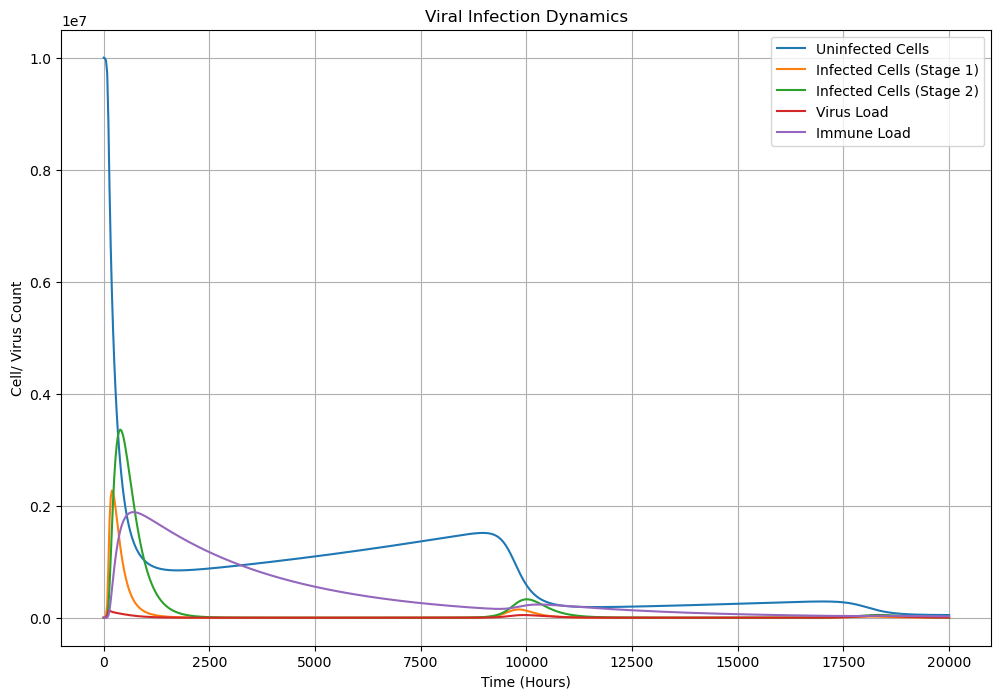

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U+I1+I2)/U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

# Parameters
beta = 7.18*600*1e-11  # infection rate
k = 1.85*600*1e-5      # infected_to_transitioning_conv_rate
d = 2.78*600*1e-6 * 2.5     # death rate
p = 3.79*600*1e-4 * .6   # virus production rate
c = 1.09*600*1e-4     # virus decay rate
cp = 1e-5 * 4
cd = 1e-4 * 3
ck = 1e-6 * 4
r = 1e-4

# Initial conditions
U0 = 1e7  # initial uninfected cells
I1_0 = 0  # initial infected cells stage 1
I2_0 = 0  # initial infected cells stage 2
A0 = 0    # initial dead cells
V0 = 1000 # initial virus load
C0 = 0 

# Time points (days)
t = np.linspace(0, 20000, 720)  # simulate for 50 days

# Initial state
y0 = [U0, I1_0, I2_0, V0, C0]

# Solve ODE
solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp ,cd, ck, U0))

# Plot results
U, I1, I2, V, C = solution.T
plt.figure(figsize=(12, 8))
plt.plot(t, U, label='Uninfected Cells')
plt.plot(t, I1, label='Infected Cells (Stage 1)')
plt.plot(t, I2, label='Infected Cells (Stage 2)')
plt.plot(t, V, label='Virus Load')
plt.plot(t, C, label='Immune Load')
plt.xlabel('Time (Hours)')
plt.ylabel('Cell/ Virus Count')
plt.legend()
plt.title('Viral Infection Dynamics')
plt.grid()
plt.show()


In [8]:
min(V), min(I1), min(I2)

(2.6129251692049595, 0.0, 0.0)

In [105]:
np.save('data/solution_sample.npy', solution[::5])

## Metoda Sobola

Poniżej przeprowadzone zostanie badanie wpływu współczynników modelu na wynik przy użyciu metody Sobola. Weźmiemy pod uwagę indeks pierwszego oraz totalnego rzędu. Pierwszy rząd bada wpływ zmiany  pojedyńczego parametru na wynik modelu, gdzie totalny rząd bada zmianę uwzględniając interakcję z innymi parametrami.

In [9]:
from SALib.sample import sobol

problem = {
    'num_vars': 13,
    'names': ['U0','I1_0','I2_0', 'V0', 'beta', 'k', 'd', 'p', 'c', 'r', 'cp', 'cd','ck'],
    'bounds': [
        [1e6, 1e8],
        [0,1e1],
        [0,1e1],
        [1e4,1e5],
        [5.18*3600*1e-8,9.18*3600*1e-8],
        [1.35*3600*1e-5,2.35*3600*1e-5],
        [2.28*3600*1e-6 ,3.28*3600*1e-6],
        [0.59*3600*1e-4,1.59*3600*1e-4],
        [0.59*3600*1e-4,1.59*3600*1e-4],
        [9e-4,1.1e-3],
        [9e-4,1.1e-3],
        [9e-5,1.1e-4],
        [8e-3,1.3e-2]
    ]
}

W badaniu wyłączony zostanie drugi rząd, który bada również interackję pomiędzy parami parametrów.

In [10]:
param_values_sobol = sobol.sample(problem, 1024, calc_second_order=False)

In [11]:
def evaluate_model(params):
    U0,I1_0,I2_0, V0,beta, k, d, p, c, r, cp, cd, ck = params
    y0 = [U0, I1_0, I2_0, V0, 0]
    solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp, cd, ck, U0))
    U, I1, I2, V, C = solution.T
    return U, I1, I2, V, C

In [12]:
from tqdm import tqdm_notebook

Us, I1s, I2s, Vs, Cs = [], [], [], [], []
for params in tqdm_notebook(param_values_sobol):
  U, I1, I2, V, C = evaluate_model(params)
  Us.append(U)
  I1s.append(I1)
  I2s.append(I2)
  Vs.append(V)
  Cs.append(C)

/var/folders/cn/mhwmm18103sbb1kd17kd3zrw0000gn/T/ipykernel_53214/3774884802.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_sobol):


  0%|          | 0/15360 [00:00<?, ?it/s]

/var/folders/cn/mhwmm18103sbb1kd17kd3zrw0000gn/T/ipykernel_53214/856488260.py:4: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp, cd, ck, U0))


In [13]:
Us = np.array(Us)
I1s = np.array(I1s)
I2s = np.array(I2s)
Cs = np.array(Cs)
Vs = np.array(Vs)

Analizuje każdy krok czasowy pojedyńczo, aby odkryć jaki wpływ współczynników jest w czasie.

In [14]:
from SALib.analyze import sobol

resultsU = []
resultsI1 = []
resultsI2 = []
resultsV = []
resultsC = []
for time_ in tqdm_notebook(range(1,360)):
  resultsU.append(sobol.analyze(problem, Us[:,time_], calc_second_order=False))
  resultsI1.append(sobol.analyze(problem, I1s[:,time_], calc_second_order=False))
  resultsI2.append(sobol.analyze(problem, I2s[:,time_], calc_second_order=False))
  resultsV.append(sobol.analyze(problem, Vs[:,time_], calc_second_order=False))
  resultsC.append(sobol.analyze(problem, Cs[:,time_], calc_second_order=False))

/var/folders/cn/mhwmm18103sbb1kd17kd3zrw0000gn/T/ipykernel_53214/350697897.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for time_ in tqdm_notebook(range(1,360)):


  0%|          | 0/359 [00:00<?, ?it/s]

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/SALib/analyze/sobol.py:216: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/SALib/analyze/sobol.py:229: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/

In [15]:
S1MatrixU = np.array([result['S1'] for result in resultsU])
STMatrixU = np.array([result['ST'] for result in resultsU])
S1MatrixI1 = np.array([result['S1'] for result in resultsI1])
STMatrixI1 = np.array([result['ST'] for result in resultsI1])
S1MatrixI2 = np.array([result['S1'] for result in resultsI2])
STMatrixI2 = np.array([result['ST'] for result in resultsI2])
S1MatrixV = np.array([result['S1'] for result in resultsV])
STMatrixV = np.array([result['ST'] for result in resultsV])
S1MatrixC = np.array([result['S1'] for result in resultsC])
STMatrixC = np.array([result['ST'] for result in resultsC])

ValueError: x and y must have same first dimension, but have shapes (719,) and (359,)

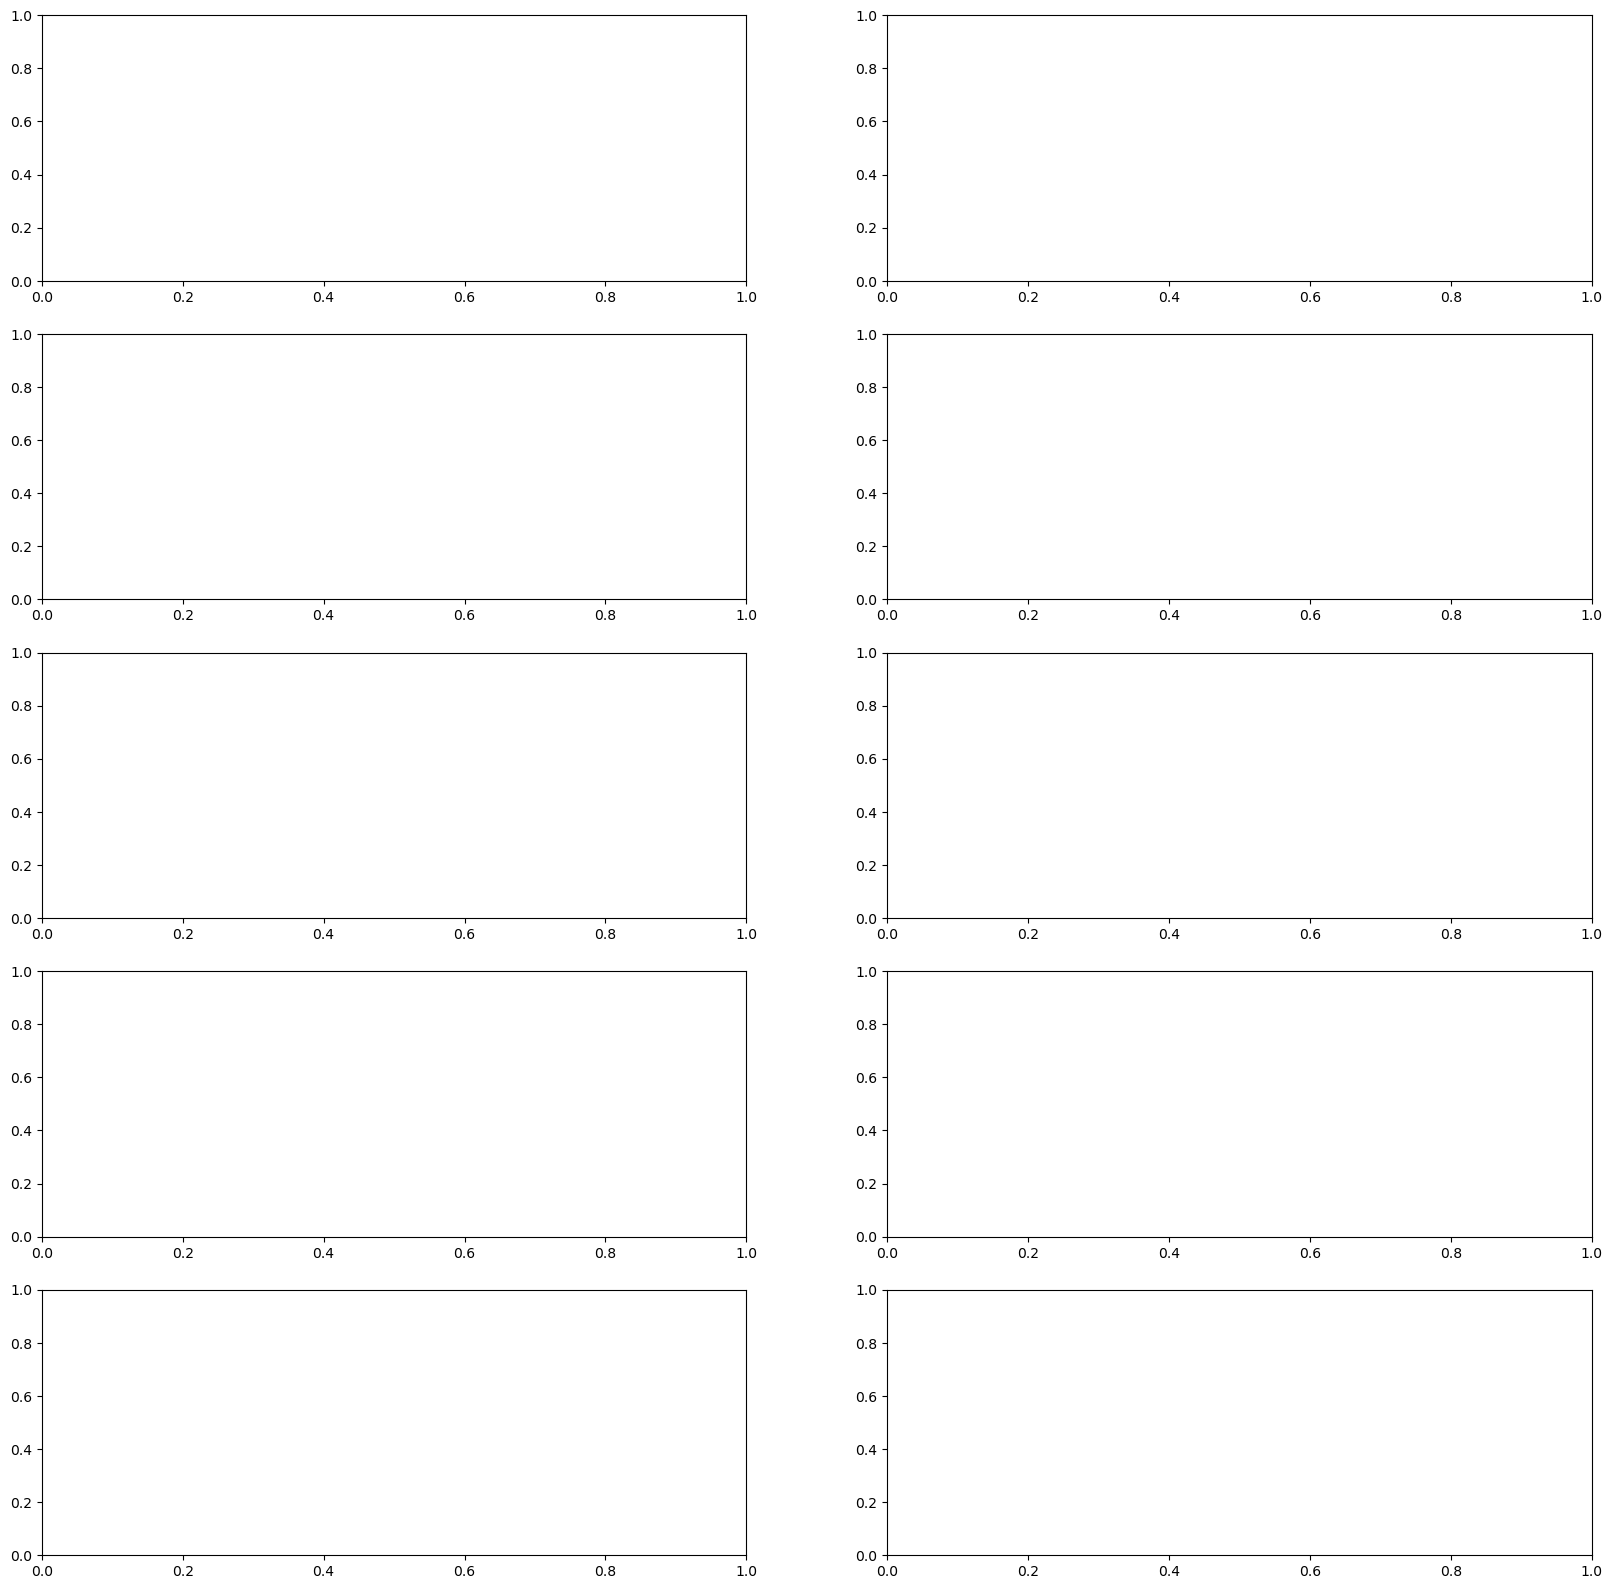

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, 9))
fig, axes = plt.subplots(5,2)
matrices = [[S1MatrixU,STMatrixU],
            [S1MatrixI1,STMatrixI1],
            [S1MatrixI2,STMatrixI2],
            [S1MatrixV,STMatrixV]]

texts = ['First order Sobel for ', 'Total order Sobel for ']
variables = ['U','I1','I2','V','C']
fig.set_size_inches(20,20)

for row in range(5):
  for col in range(2):
    for name, col_, color_ in zip(problem['names'],range(13),color):
      axes[row,col].plot(t[1:], matrices[row][col][:,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
      axes[row,col].grid()
      axes[row,col].set_title(texts[col] + variables[row])


handles, labels = axes[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

In [3]:
problem = {
    'num_vars': 8,
    'names': ['I1_0','I2_0', 'V0', 'beta', 'k', 'd', 'p', 'c'],
    'bounds': [
        [0,1e3],
        [0,1e3],
        [1e4,1e5],
        [5.18*3600*1e-8,9.18*3600*1e-8],
        [1.35*3600*1e-5,2.35*3600*1e-5],
        [2.28*3600*1e-6 ,3.28*3600*1e-6],
        [0.59*3600*1e-4,1.59*3600*1e-4],
        [0.59*3600*1e-4,1.59*3600*1e-4]
    ]
}

In [22]:
def evaluate_model2(params):
    I1_0,I2_0, V0, beta, k, d, p, c = params
    y0 = [1e7-I1_0-I2_0, I1_0, I2_0, 0, V0]
    solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c))
    U, I1, I2, A, V = solution.T
    return U, I1, I2, A, V

In [25]:
from SALib.sample import sobol as sobol_sampler
param_values_sobol2 = sobol_sampler.sample(problem, 1024, calc_second_order=False)

In [26]:
from tqdm import tqdm_notebook

Uss, I1ss, I2ss, Ass, Vss = [], [], [], [], []
for params in tqdm_notebook(param_values_sobol2):
  U, I1, I2, A, V = evaluate_model2(params)
  Uss.append(U)
  I1ss.append(I1)
  I2ss.append(I2)
  Ass.append(A)
  Vss.append(V)

/var/folders/cn/mhwmm18103sbb1kd17kd3zrw0000gn/T/ipykernel_53214/1518530072.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_sobol2):


  0%|          | 0/10240 [00:00<?, ?it/s]

TypeError: viral_infection_model() missing 5 required positional arguments: 'r', 'cp', 'cd', 'ck', and 'U_max'

In [20]:
Uss = np.array(Uss)
I1ss = np.array(I1ss)
I2ss = np.array(I2ss)
Ass = np.array(Ass)
Vss = np.array(Vss)

NameError: name 'Uss' is not defined

In [ ]:
from SALib.analyze import sobol

resultsUs = []
resultsI1s = []
resultsI2s = []
resultsAs = []
resultsVs = []
for time_ in tqdm_notebook(range(1,720)):
  resultsUs.append(sobol.analyze(problem, Uss[:,time_], calc_second_order=False))
  resultsI1s.append(sobol.analyze(problem, I1ss[:,time_], calc_second_order=False))
  resultsI2s.append(sobol.analyze(problem, I2ss[:,time_], calc_second_order=False))
  resultsAs.append(sobol.analyze(problem, Ass[:,time_], calc_second_order=False))
  resultsVs.append(sobol.analyze(problem, Vss[:,time_], calc_second_order=False))

<ipython-input-170-c5af9df29939>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for time_ in tqdm_notebook(range(1,720)):


  0%|          | 0/719 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [ ]:
S1MatrixUs = np.array([result['S1'] for result in resultsUs])
STMatrixUs = np.array([result['ST'] for result in resultsUs])
S1MatrixI1s = np.array([result['S1'] for result in resultsI1s])
STMatrixI1s = np.array([result['ST'] for result in resultsI1s])
S1MatrixI2s = np.array([result['S1'] for result in resultsI2s])
STMatrixI2s = np.array([result['ST'] for result in resultsI2s])
S1MatrixAs = np.array([result['S1'] for result in resultsAs])
STMatrixAs = np.array([result['ST'] for result in resultsAs])
S1MatrixVs = np.array([result['S1'] for result in resultsVs])
STMatrixVs = np.array([result['ST'] for result in resultsVs])

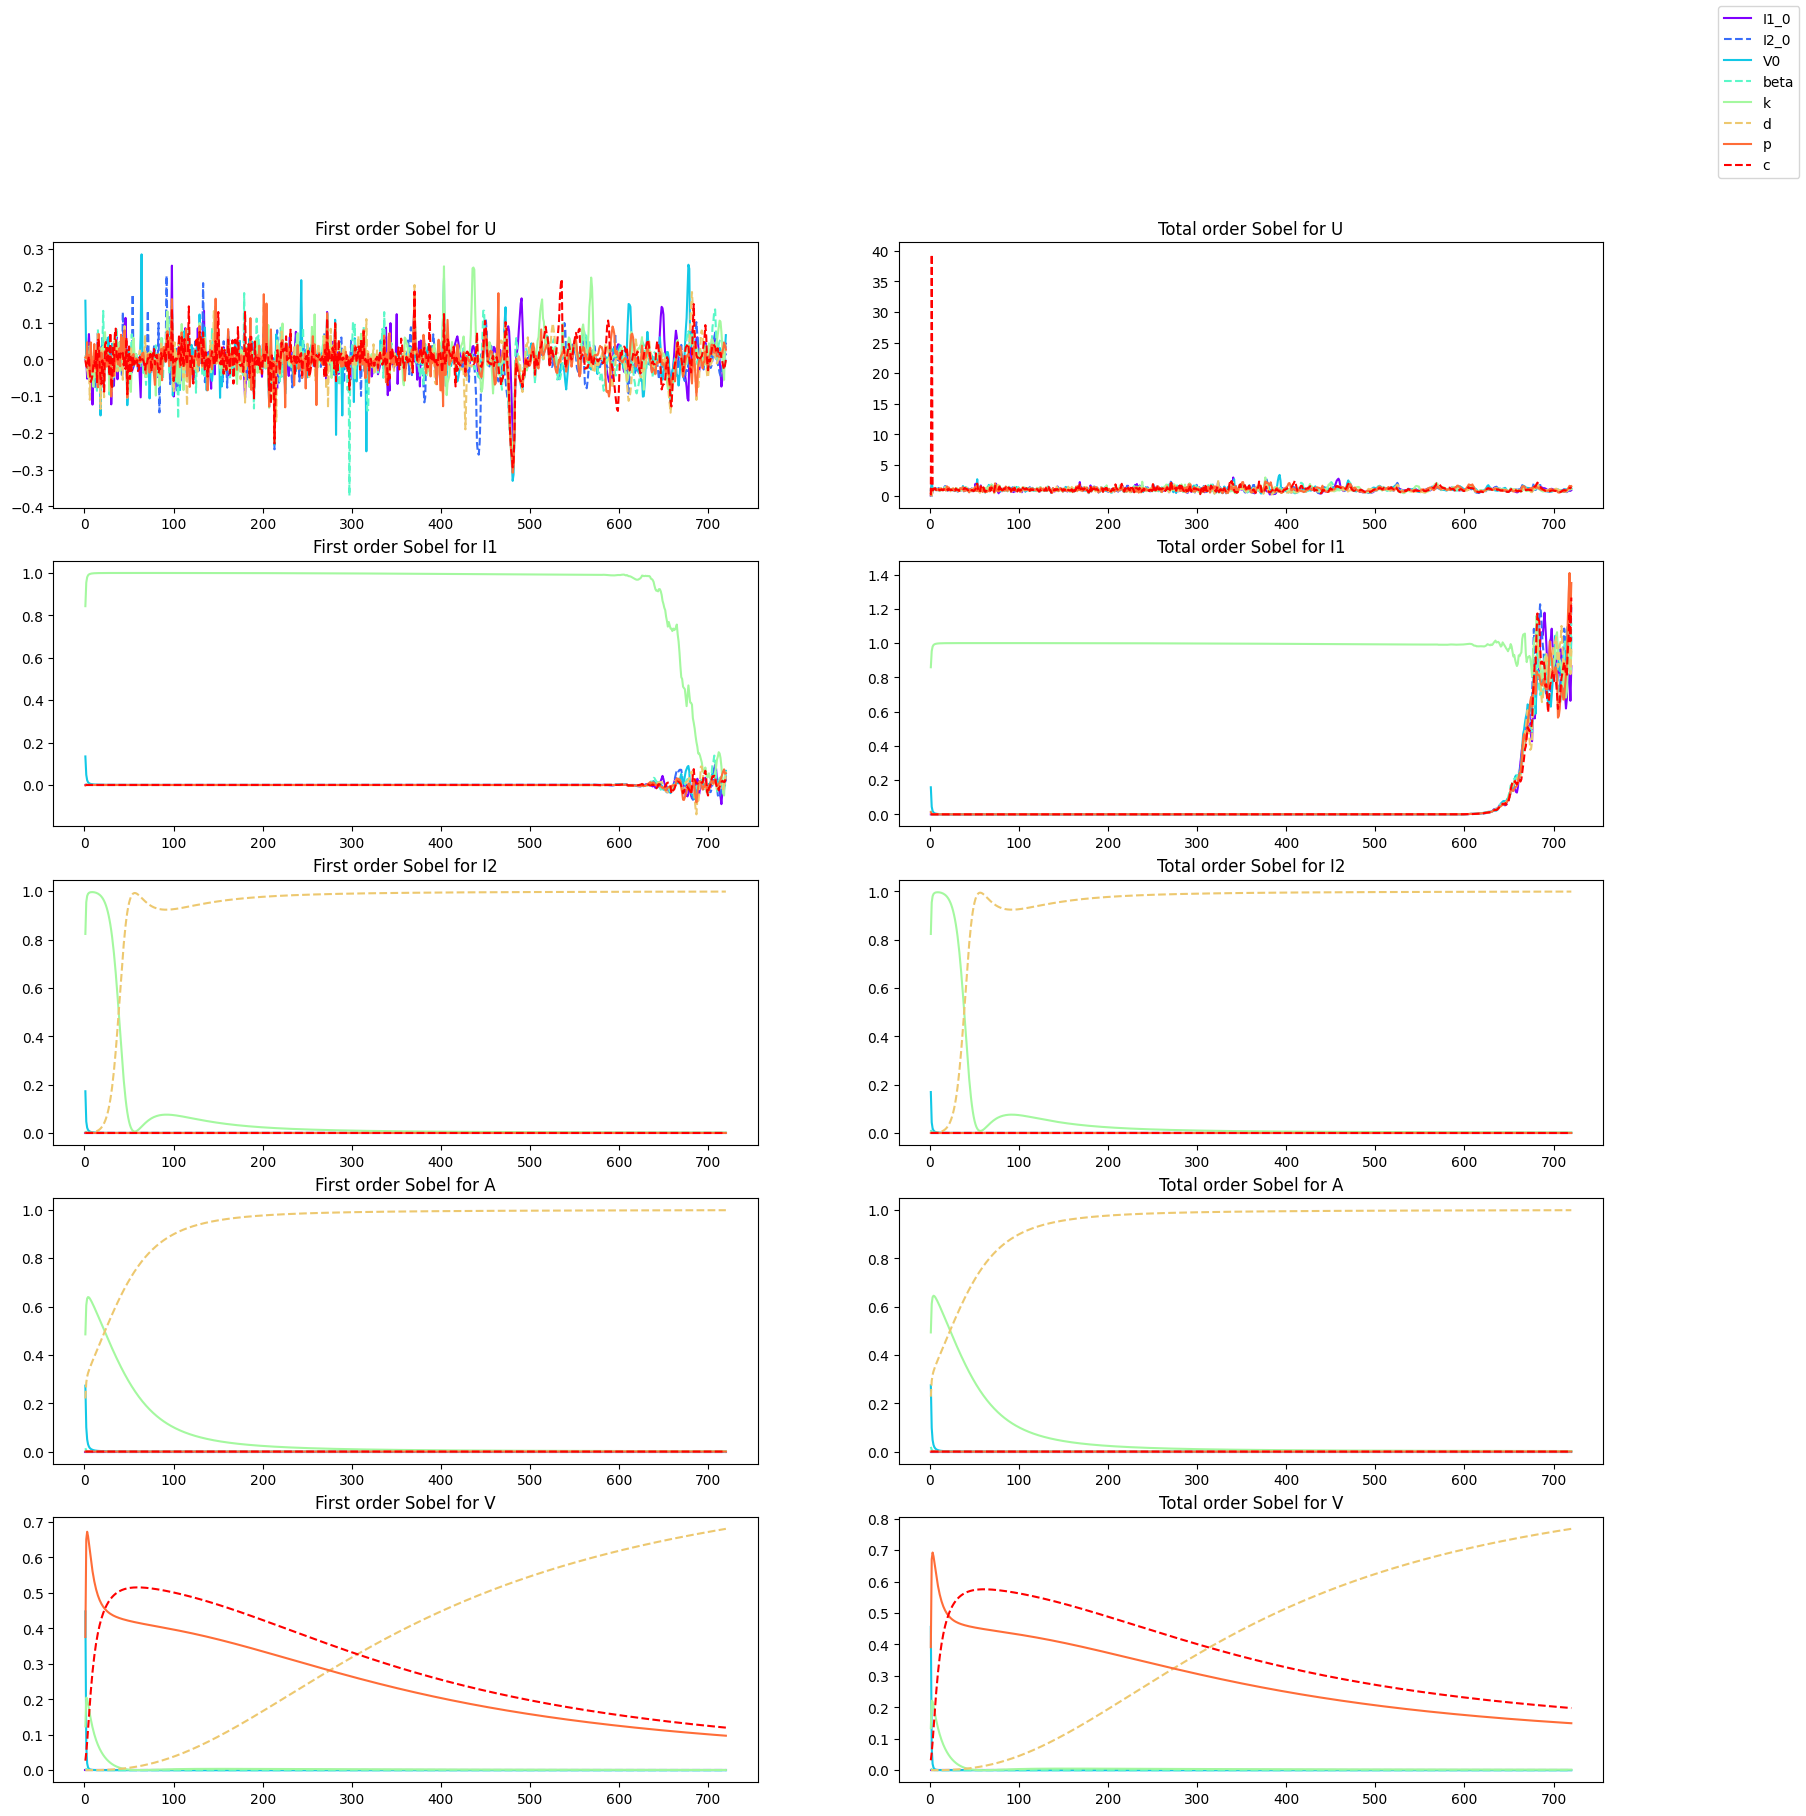

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, 8))
fig, axes = plt.subplots(5,2)
matrices = [[S1MatrixUs,STMatrixUs],
            [S1MatrixI1s,STMatrixI1s],
            [S1MatrixI2s,STMatrixI2s],
            [S1MatrixAs,STMatrixAs],
            [S1MatrixVs,STMatrixVs]]

texts = ['First order Sobel for ', 'Total order Sobel for ']
variables = ['U','I1','I2','A','V']
fig.set_size_inches(20,20)

for row in range(5):
  for col in range(2):
    for name, col_, color_ in zip(problem['names'],range(8),color):
      axes[row,col].plot(t[1:], matrices[row][col][:,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
      axes[row,col].grid()
      axes[row,col].set_title(texts[col] + variables[row])


handles, labels = axes[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

In [ ]:
problem = {
    'num_vars': 7,
    'names': ['I1_0','I2_0', 'V0', 'k', 'd', 'p', 'c'],
    'bounds': [
        [0,1e3],
        [0,1e3],
        [1e4,1e5],
        [1.35*3600*1e-5,2.35*3600*1e-5],
        [2.28*3600*1e-6 ,3.28*3600*1e-6],
        [0.59*3600*1e-4,1.59*3600*1e-4],
        [0.59*3600*1e-4,1.59*3600*1e-4]
    ]
}

In [ ]:
def evaluate_model3(params):
    I1_0,I2_0, V0, k, d, p, c = params
    y0 = [1e7-I1_0-I2_0, I1_0, I2_0, 0, V0]
    solution = odeint(viral_infection_model, y0, t, args=(9.18*3600*1e-8, k, d, p, c))
    U, I1, I2, A, V = solution.T
    return U, I1, I2, A, V

In [ ]:
from SALib.sample import sobol
param_values_sobol3 = sobol.sample(problem, 1024, calc_second_order=False)

In [ ]:
from tqdm import tqdm_notebook

Usss, I1sss, I2sss, Asss, Vsss = [], [], [], [], []
for params in tqdm_notebook(param_values_sobol3):
  U, I1, I2, A, V = evaluate_model3(params)
  Usss.append(U)
  I1sss.append(I1)
  I2sss.append(I2)
  Asss.append(A)
  Vsss.append(V)

<ipython-input-182-2d086d28eee0>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_sobol3):


  0%|          | 0/9216 [00:00<?, ?it/s]

In [ ]:
Usss = np.array(Usss)
I1sss = np.array(I1sss)
I2sss = np.array(I2sss)
Asss = np.array(Asss)
Vsss = np.array(Vsss)

In [ ]:
from SALib.analyze import sobol

resultsUss = []
resultsI1ss = []
resultsI2ss = []
resultsAss = []
resultsVss = []
for time_ in tqdm_notebook(range(1,720)):
  resultsUss.append(sobol.analyze(problem, Usss[:,time_], calc_second_order=False))
  resultsI1ss.append(sobol.analyze(problem, I1sss[:,time_], calc_second_order=False))
  resultsI2ss.append(sobol.analyze(problem, I2sss[:,time_], calc_second_order=False))
  resultsAss.append(sobol.analyze(problem, Asss[:,time_], calc_second_order=False))
  resultsVss.append(sobol.analyze(problem, Vsss[:,time_], calc_second_order=False))

<ipython-input-184-89b5d8d913fb>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for time_ in tqdm_notebook(range(1,720)):


  0%|          | 0/719 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [ ]:
S1MatrixUss = np.array([result['S1'] for result in resultsUss])
STMatrixUss = np.array([result['ST'] for result in resultsUss])
S1MatrixI1ss = np.array([result['S1'] for result in resultsI1ss])
STMatrixI1ss = np.array([result['ST'] for result in resultsI1ss])
S1MatrixI2ss = np.array([result['S1'] for result in resultsI2ss])
STMatrixI2ss = np.array([result['ST'] for result in resultsI2ss])
S1MatrixAss = np.array([result['S1'] for result in resultsAss])
STMatrixAss = np.array([result['ST'] for result in resultsAss])
S1MatrixVss = np.array([result['S1'] for result in resultsVss])
STMatrixVss = np.array([result['ST'] for result in resultsVss])

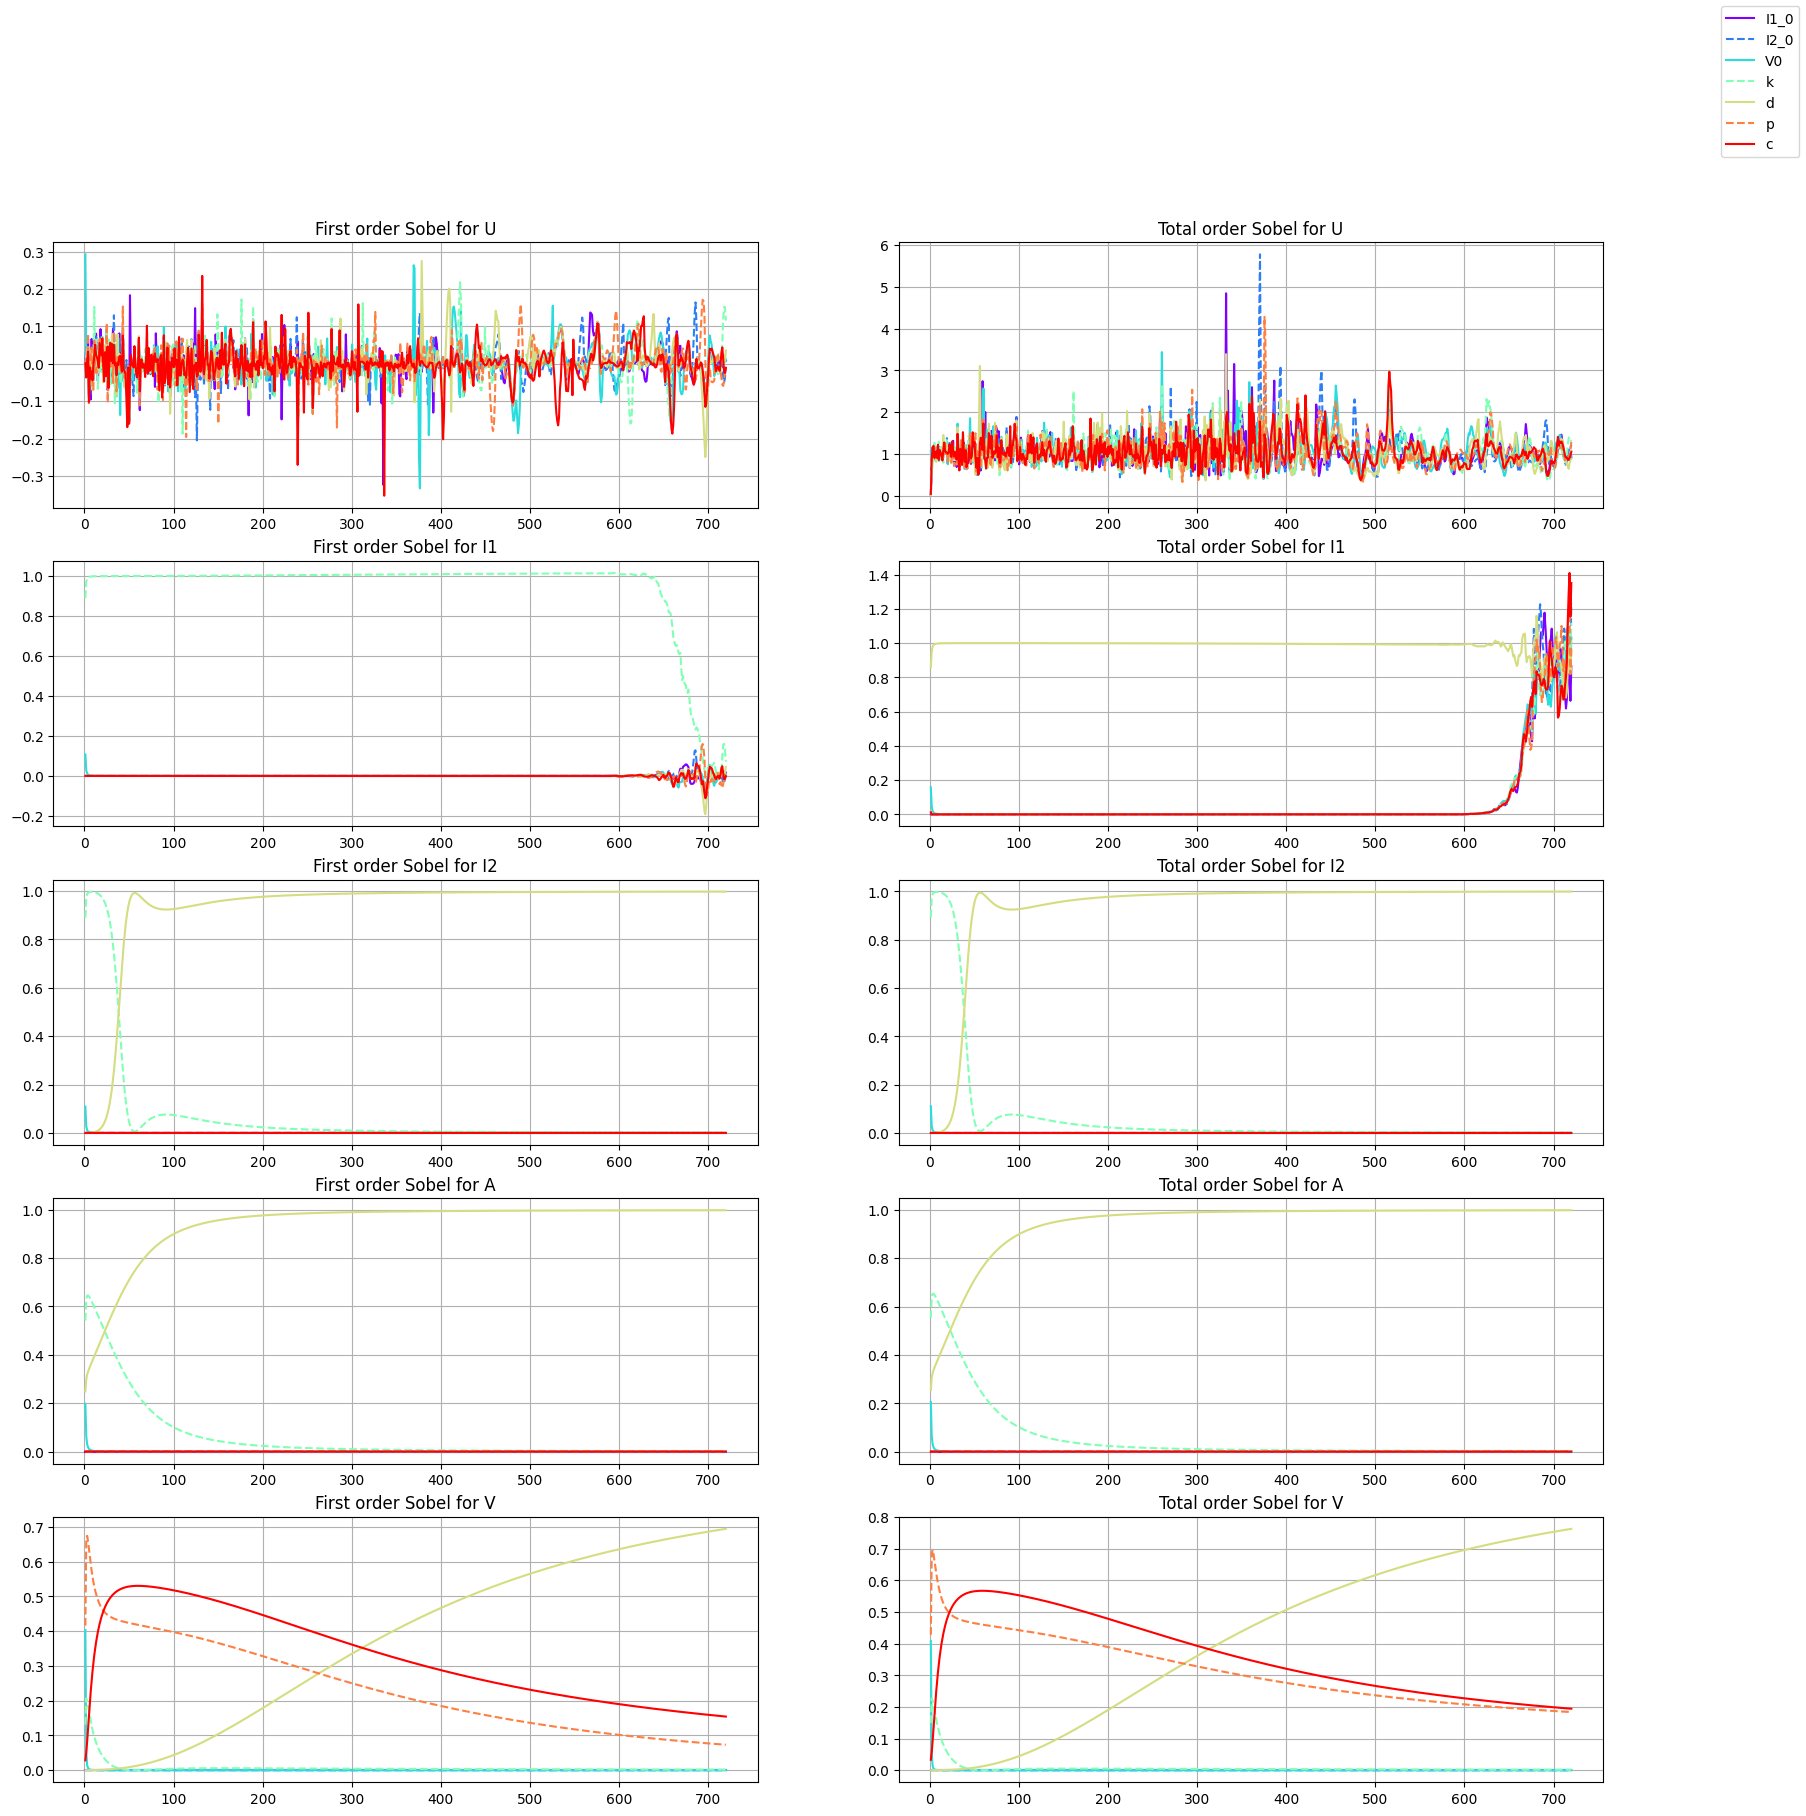

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, 7))
fig, axes = plt.subplots(5,2)
matrices = [[S1MatrixUss,STMatrixUss],
            [S1MatrixI1ss,STMatrixI1s],
            [S1MatrixI2ss,STMatrixI2ss],
            [S1MatrixAss,STMatrixAss],
            [S1MatrixVss,STMatrixVss]]

texts = ['First order Sobel for ', 'Total order Sobel for ']
variables = ['U','I1','I2','A','V']
fig.set_size_inches(20,20)

for row in range(5):
  for col in range(2):
    for name, col_, color_ in zip(problem['names'],range(7),color):
      axes[row,col].plot(t[1:], matrices[row][col][:,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
      axes[row,col].grid()
      axes[row,col].set_title(texts[col] + variables[row])


handles, labels = axes[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

## Meroda Morrisa

Poniżej zostanie użyta metoda Morrisa, dokładnie w tym samym celu co Sobola. Będziemy używać metryki u* (wartość oczekiwana dla wartości elementarnych absolutnych), która oznacza siłę wpływu danego parametru (bez interakcji) na wynik modelu.

In [ ]:
from SALib.sample import morris as morris_sample
from SALib.analyze import morris as morris_analyze

param_values = morris_sample.sample(problem, 1024)

In [ ]:
param_values.shape

(14336, 13)

In [ ]:
MUs = []
for params in tqdm_notebook(param_values):
  res = evaluate_model(params)
  MUs.append(res[0])

/tmp/ipykernel_38541/4134208182.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values):


  0%|          | 0/14336 [00:00<?, ?it/s]

/tmp/ipykernel_38541/856488260.py:4: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp, cd, ck, U0))


In [ ]:
MUs = np.array(MUs)


In [ ]:
resultsMU = []
for time_ in range(1,360):
  resultsMU.append(morris_analyze.analyze(problem, param_values,MUs[:,time_]))

/home/zogfryt/Informatyka_Systemow_Zlozonych/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/zogfryt/Informatyka_Systemow_Zlozonych/.venv/lib/python3.12/site-packages/SALib/analyze/morris.py:412: RuntimeWarning: overflow encountered in divide
  elementary_effects = difference / delta


In [ ]:
MuMatrixA = np.array([result['mu_star'] for result in resultsMU])

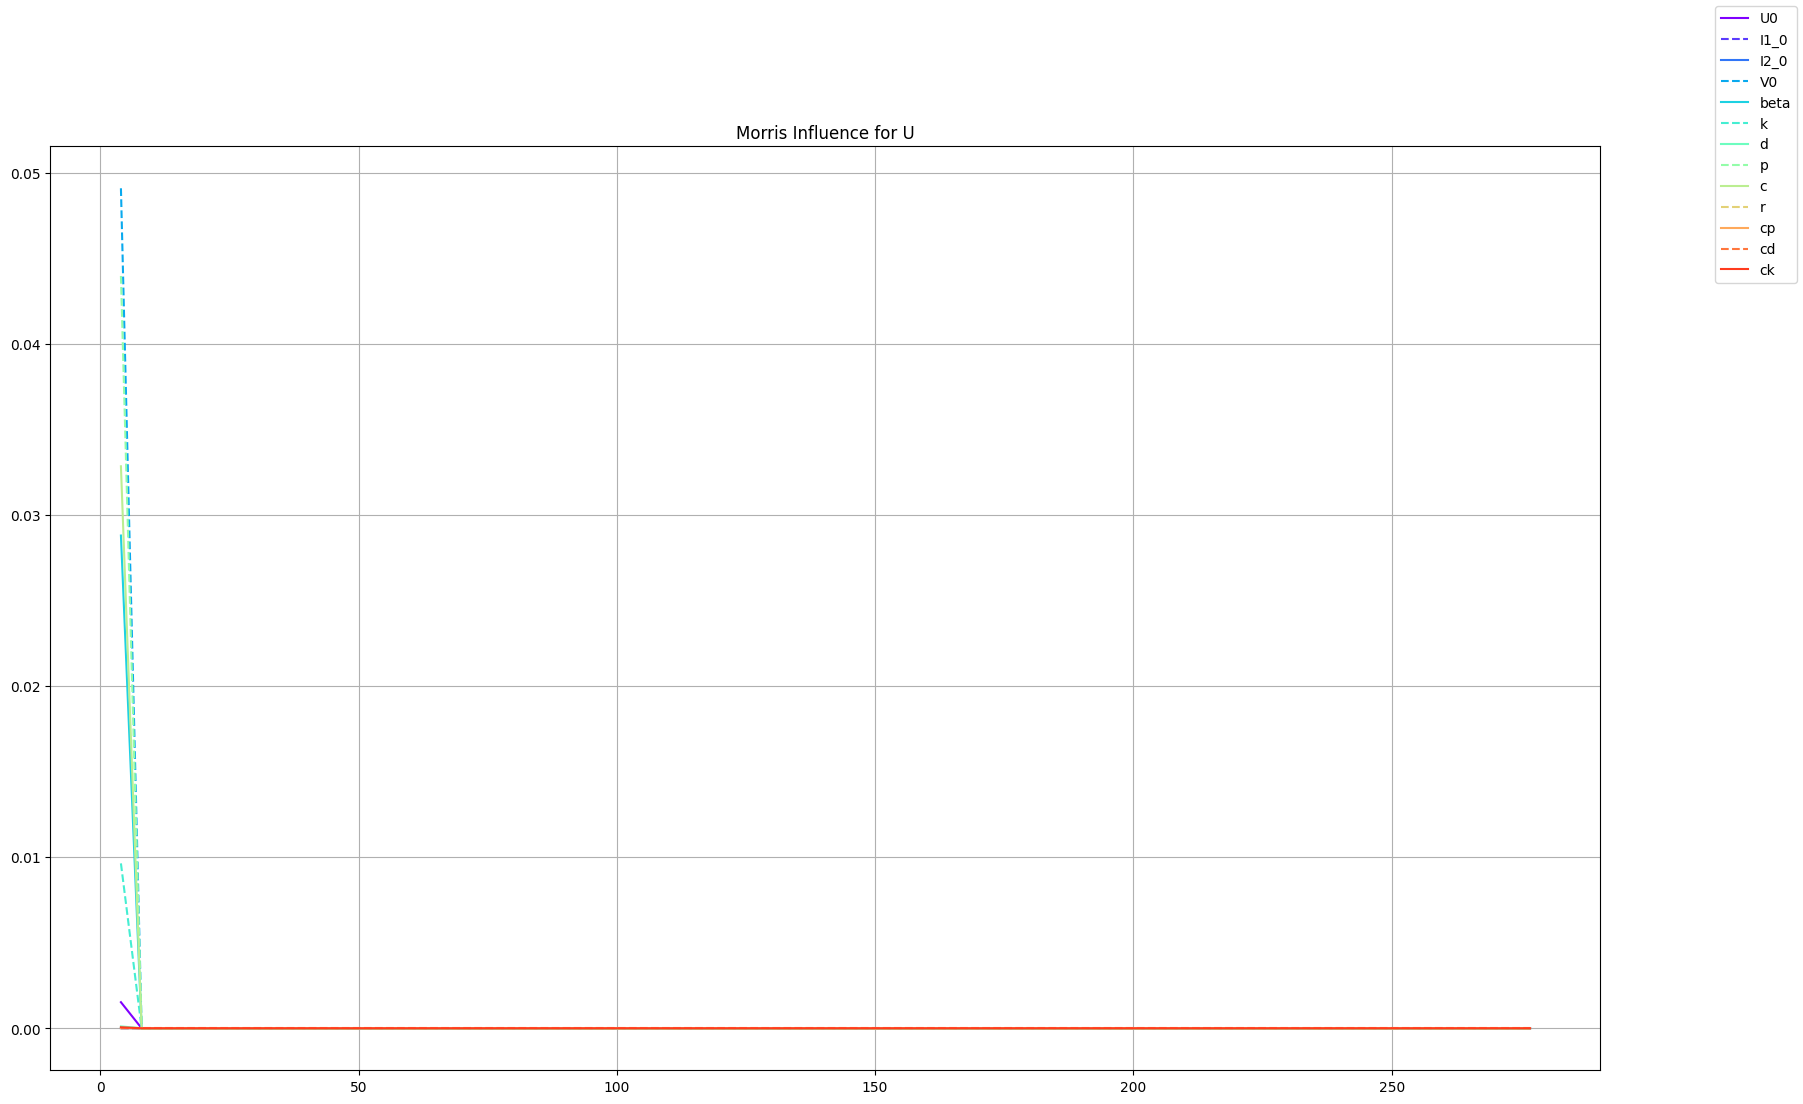

In [ ]:
fig, axes = plt.subplots(1,1)
matrices = [MuMatrixA]

color = cm.rainbow(np.linspace(0, 1, 14))
texts = ['Morris Influence for ']
variables = ['U']
fig.set_size_inches(20,12)

for col in range(1):
    for name, col_, color_ in zip(problem['names'],range(13),color):
      axes.plot(t[1:70], matrices[col][:69,col_],'-'*(1+(col_ % 2)),label=name, c=color_)
      axes.grid()
      axes.set_title(texts[0] + variables[col])


handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

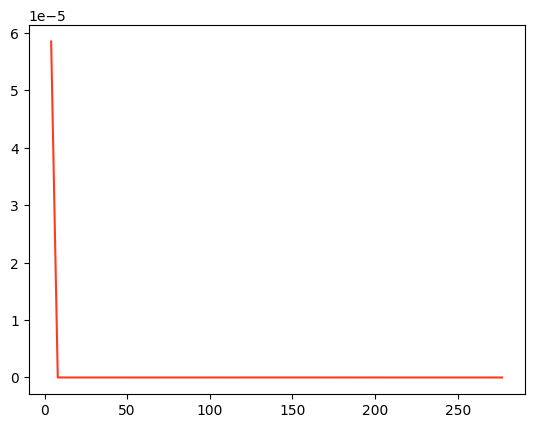

In [ ]:

plt.plot(t[1:70], matrices[col][:69,col_],'-'*(1+(col_ % 2)),label=name, c=color_)

In [ ]:
t[1:20]

array([ 4.01114206,  8.02228412, 12.03342618, 16.04456825, 20.05571031,
       24.06685237, 28.07799443, 32.08913649, 36.10027855, 40.11142061,
       44.12256267, 48.13370474, 52.1448468 , 56.15598886, 60.16713092,
       64.17827298, 68.18941504, 72.2005571 , 76.21169916])

Najmniej czułe parametry:
* L
* t_ceof
* B0
* R0
* A0
* K
* h

Według Morrisa to są najmniej wpływające parametry na nasz model. Znów powtarza się sytuacja, gdzie model jest nie reaguje zbyt mocno na zmiany wartości początkowych.

Podsumowując zbiorczo. Najmnniej oddziałujące parametry na wyniki modelu, to wszystkie wartości oraz L oraz t_ceof. Innymi słowy te dwa parametry to jest maksymalna wielkość zasobów o który biją się obie firmy (L) oraz wpływ wielkości zasobów na wzrost firmy start-up (t_ceof). Wynika to że ich zmiana nieznacznie wpływa na wyniki modelu, przez co są to parametry mniej ważne.

Najczulsze parametry w testach Morrisa oraz Sobola to u oraz v. "u" jest to szybkość w jakim tempie rośnie zasób, o który biją się firmy oraz "v" odwrotną metryką, która oznacza jak szybko zasób się kurczy (jak szybko zasoby rynkowe są spalane przez firmy). Oznacza to jak bardzo ważną kwestią jest istnienie zasobów dla obu firm. Zmiana tych parametrów, będzie wpływała bardzo mocno na wyniki symulowanego średowiska.

Zrobimy ponownie omawiane testy, lecz wyrzucając z rozważania parametry, które są najmniej czułe.

In [ ]:
from SALib.sample import sobol
problem = {
    'num_vars': 9,
    'names': ['r', 'K', 'a', 'h', 'e', 'd', 's', 'u', 'v'],
    'bounds': [
        [1.5, 2.5],
        [50, 70],
        [0.075, 0.125],
        [0.02, 0.04],
        [0.4, 0.6],
        [0.15, 0.25],
        [0.2, 0.4],
        [1.25, 1.75],
        [0.02, 0.04]
    ]
}

In [ ]:
param_values_sobol_s = sobol.sample(problem, 1024, calc_second_order=False)

W nowych testach damy wartości inne niż w bazowym modelu dla wartości początkowych. Zmiana ich nie powinna wpływać na działanie modelu znacząco. Ustawmy je trochę inaczej. Firma A zaczyna mniejsza (40 -> 35), za to rynek i firma B są większe (B0: 9 -> 11)(R0: 50 -> 55).
Parametry L oraz t_ceof zmniejszymy natomiat lekko (L: 100 -> 95) (t_ceof: 0.2 -> 0.18)

In [ ]:
def evaluate_model_smaller(params):
    r, K, a, h, e, d, s, u, v = params
    y0 = [35,11,55]
    solution = odeint(model, y0, t, args=(r, K, a, h, e, d, s, 0.18, u, 95, v))
    A, B, R = solution.T
    return A, B, R

In [ ]:
from tqdm import tqdm_notebook

As_small, Bs_small, Rs_small = [], [], []
for params in tqdm_notebook(param_values_sobol_s):
  A,B,R = evaluate_model_smaller(params)
  As_small.append(A)
  Bs_small.append(B)
  Rs_small.append(R)

<ipython-input-53-b50b46e361f5>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_sobol_s):


  0%|          | 0/11264 [00:00<?, ?it/s]

In [ ]:
As_small = np.array(As_small)
Bs_small = np.array(Bs_small)
Rs_small = np.array(Rs_small)

In [ ]:
from SALib.analyze import sobol

resultsA_small = []
resultsB_small = []
resultsR_small = []
for time_ in range(1,50):
  resultsA_small.append(sobol.analyze(problem, As_small[:,time_], calc_second_order=False))
  resultsB_small.append(sobol.analyze(problem, Bs_small[:,time_], calc_second_order=False))
  resultsR_small.append(sobol.analyze(problem, Rs_small[:,time_], calc_second_order=False))

/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [ ]:
S1MatrixA_small = np.array([result['S1'] for result in resultsA_small])
STMatrixA_small = np.array([result['ST'] for result in resultsA_small])
S1MatrixB_small = np.array([result['S1'] for result in resultsB_small])
STMatrixB_small = np.array([result['ST'] for result in resultsB_small])
S1MatrixR_small = np.array([result['S1'] for result in resultsR_small])
STMatrixR_small = np.array([result['ST'] for result in resultsR_small])

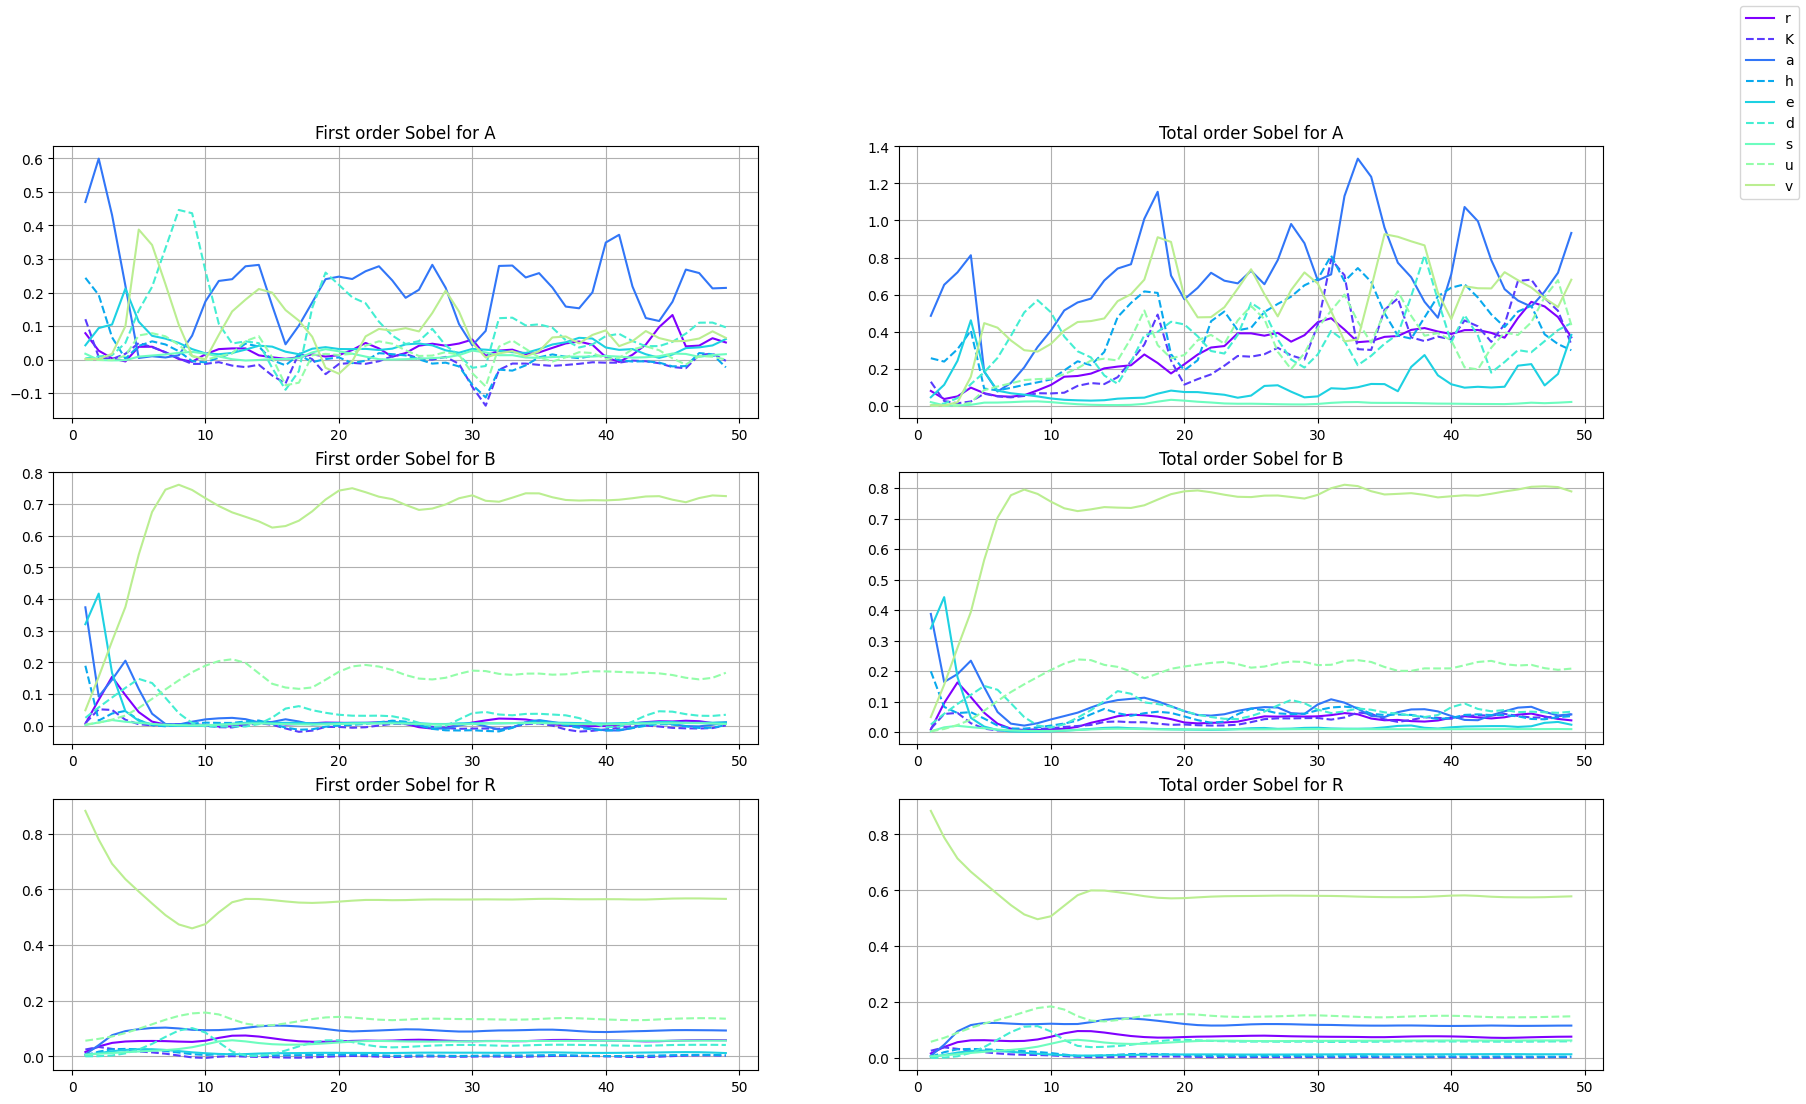

In [ ]:
color = cm.rainbow(np.linspace(0, 1, 14))
fig, axes = plt.subplots(3,2)
matrices = [[S1MatrixA_small,STMatrixA_small],
            [S1MatrixB_small,STMatrixB_small],
            [S1MatrixR_small,STMatrixR_small]]

texts = ['First order Sobel for ', 'Total order Sobel for ']
variables = ['A','B','R']
fig.set_size_inches(20,12)

for row in range(3):
  for col in range(2):
    for name, col_, color_ in zip(problem['names'],range(9),color):
      axes[row,col].plot(t[1:], matrices[row][col][:,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
      axes[row,col].grid()
      axes[row,col].set_title(texts[col] + variables[row])


handles, labels = axes[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

O ile wyniki dla zmiennej dynamicznej R oraz B są praktycznie takie same (gdzie wpływ parametrów najmniej czułych był praktycznie 0-wy), to dla zmiennejn dynamicznej A widać pewne zmiany. Wpływy na zmienność są lekko zwiększone. Również widać o wiele większy wpływ parametru "a". To on zwiększył skale, znacznie wybijając się swoim wpływem na tle innych parametrów w plocie totalnego Sobola. Jeśli chodzi o wykres Sobola, dla pierwszego stopnia (first order) wyniki nieznacznie odbiegają od poprzednich. Powodem może być inne samplowanie (mamy mniej próbek od poprzedniego 11k vs 16k) oraz zamrożenie zmian wartości parametrów o niskiej czułości dla tych testów (miały mały wpływ na zmienną dynamiczną A, ale nie zerowy).

In [ ]:
param_values_s = morris_sample.sample(problem, 1024)

In [ ]:
MAs_small, MBs_small, MRs_small = [], [], []
for params in tqdm_notebook(param_values_s):
  A,B,R = evaluate_model_smaller(params)
  MAs_small.append(A)
  MBs_small.append(B)
  MRs_small.append(R)

<ipython-input-88-33950fc3b3ca>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_s):


  0%|          | 0/10240 [00:00<?, ?it/s]

In [ ]:
MAs_small = np.array(MAs_small)
MBs_small = np.array(MBs_small)
MRs_small = np.array(MRs_small)

In [ ]:
resultsMA_small = []
resultsMB_small = []
resultsMR_small = []
for time_ in range(1,50):
  resultsMA_small.append(morris_analyze.analyze(problem, param_values_s,MAs_small[:,time_]))
  resultsMB_small.append(morris_analyze.analyze(problem, param_values_s,MBs_small[:,time_]))
  resultsMR_small.append(morris_analyze.analyze(problem, param_values_s,MRs_small[:,time_]))

In [ ]:
MuMatrixA_small = np.array([result['mu_star'] for result in resultsMA_small])
MuMatrixB_small = np.array([result['mu_star'] for result in resultsMB_small])
MuMatrixR_small = np.array([result['mu_star'] for result in resultsMR_small])

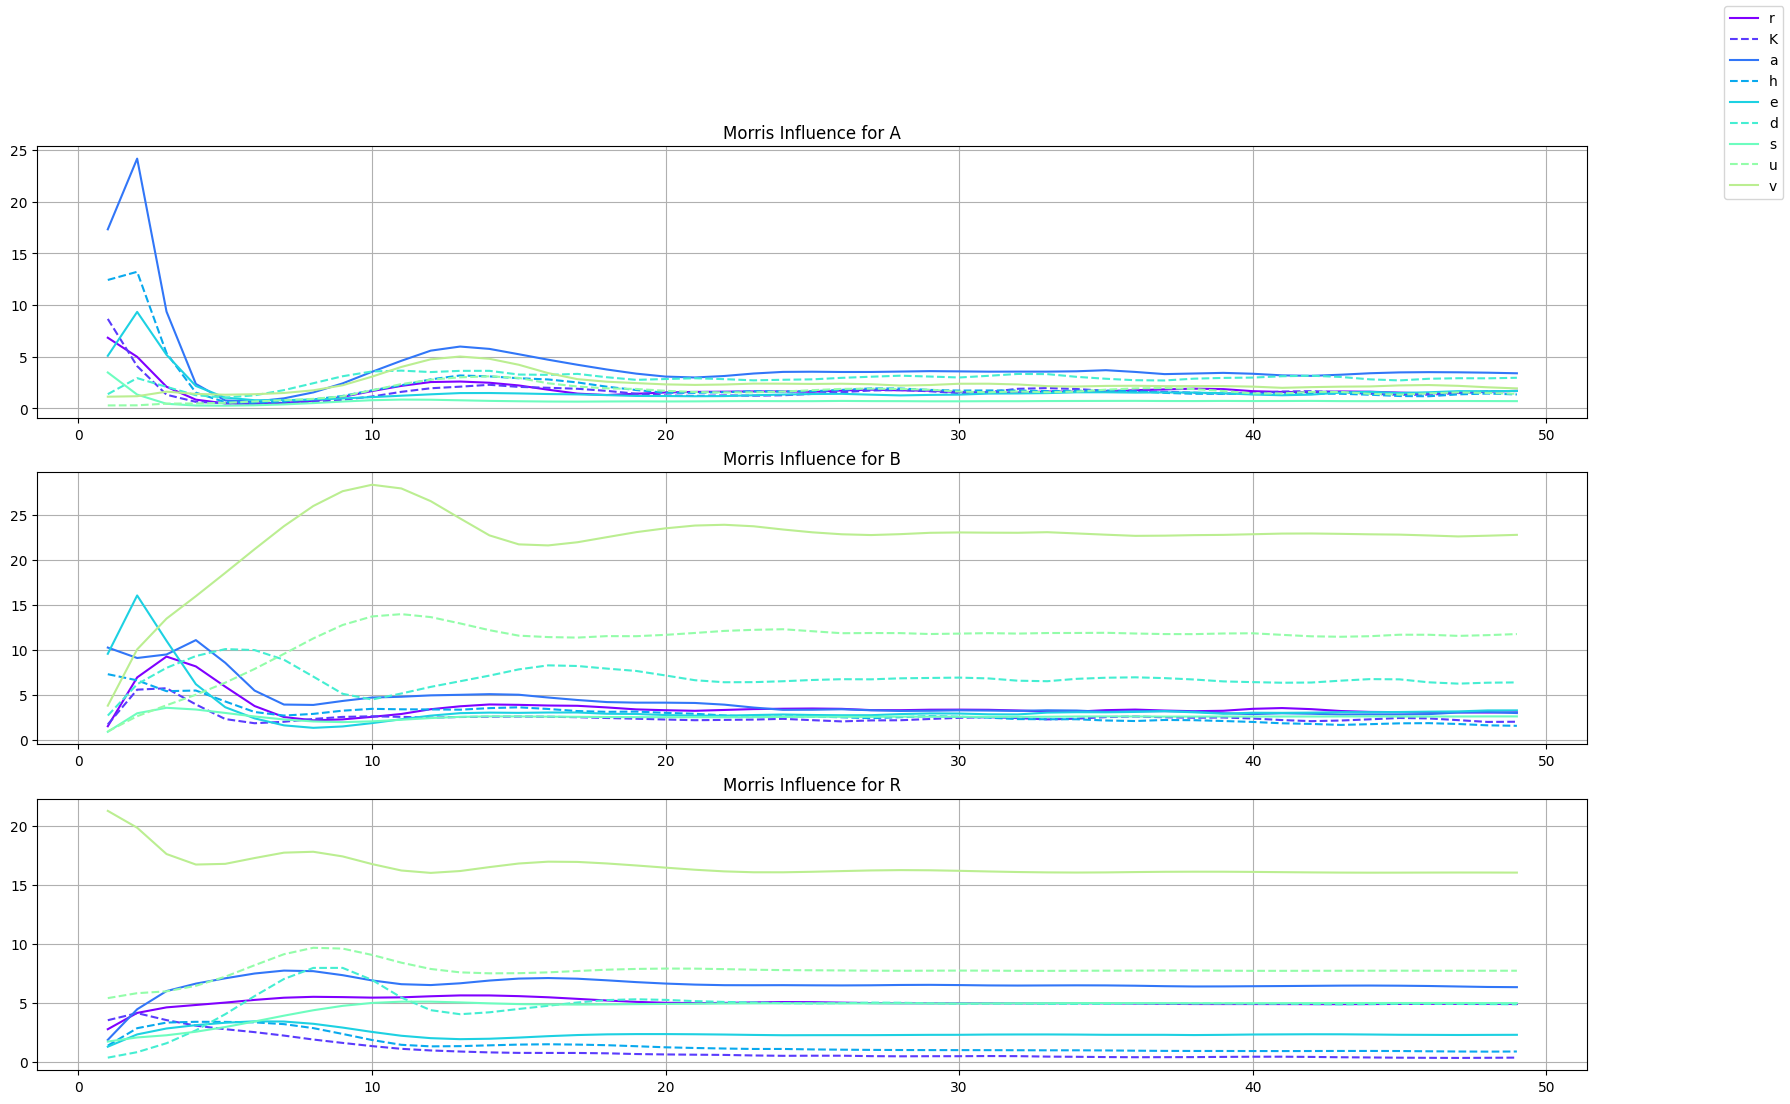

In [ ]:
fig, axes = plt.subplots(3,1)
matrices = [MuMatrixA_small,MuMatrixB_small,MuMatrixR_small]

color = cm.rainbow(np.linspace(0, 1, 14))
texts = ['Morris Influence for ']
variables = ['A','B','R']
fig.set_size_inches(20,12)

for col in range(3):
    for name, col_, color_ in zip(problem['names'],range(9),color):
      axes[col].plot(t[1:], matrices[col][:,col_],'-'*(1+(col_ % 2)),label=name, c=color_)
      axes[col].grid()
      axes[col].set_title(texts[0] + variables[col])


handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

Dla Morrisa wyniki są praktycznie take same, co w testach bez zamrażania współczynników najmniej wpływających na model. Lekkie zmiany mogą wynikać z małego wpływu tamtych czynników na wynik.

Podsumowaując, zamrażanie małych parametrów nadal wpływa (w zależności od tego jak bardzo odbiegały od 0), na wyniki wpływu innych parametrów na wynik. W przypadku Morrisa oraz Sobola pierwszego rzędu, zmiany nie były aż tak widoczne. Głównie dlatego, że badane tam jest bezpośredni wpływ zmiany jednego czynnika na wynik. Jednak w Sobolu totalnego rzędu, zmiany były bardzo odczuwalne, wybijając jeden ze wskaźników znacząco w górę. Może to być przez to, że zamrożone parametry, miały tam większy wpływ niż 0 oraz badanie wpływu wraz z interakcjami pomiędzy różnymi parametrami.

## Analiza czułości, a interpretacja wyników symulacji

Analiza czułości może być używana do przebadania wpływu poszczególnych parametrów na wyniki oraz dzięki temu, sprawdzenie które parametry są ważniejsze, a które mniej ważne. Pomaga to w wytłumaczeniu modelu oraz ułatwia dostosowanie modelu do realnej próbki danych z testów przeprowadzonych na systemie który chcemy symulować. Pozwala również wyjaśnić dynamikę środowiska symulowanego, wyjaśniając jego działanie oraz zależności.

In [ ]:
! pip install pypesto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.0/411.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
! pip install SALib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00


## DATA ASIMILATION

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pypesto
import pypesto.optimize as optimize
from pypesto.objective import Objective

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U + I1 + I2) / U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

# Parameters
true_params = {
    "beta": 7.18 * 600 * 1e-11,
    "k": 1.85 * 600 * 1e-5,
    "d": 2.78 * 600 * 1e-6 * 2.5,
    "p": 3.79 * 600 * 1e-4 * 0.6,
    "c": 1.09 * 600 * 1e-4,
    "cp": 1e-5 * 4,
    "cd": 1e-4 * 3,
    "ck": 1e-6 * 4,
    "r": 1e-4,
}
start_params = {
    "beta": 7.18 * 550 * 1e-11,
    "k": 1.85 * 550 * 1e-5,
    "d": 2.78 * 550 * 1e-6 * 2.5,
    "p": 3.79 * 550 * 1e-4 * 0.6,
    "c": 1.09 * 550 * 1e-4,
    "cp": 1e-5 * 4.2,
    "cd": 1e-4 * 3.2,
    "ck": 1e-6 * 4.2,
    "r": 1e-4,
}

# Initial conditions and time points
y0 = [1e7, 0, 0, 1000, 0]
t = np.linspace(0, 13888, 500) # mult by 27.7

# Simulate true data
def simulate_model(params, tt):
    args = (
        params["beta"],
        params["k"],
        params["d"],
        params["p"],
        params["c"],
        params["r"],
        params["cp"],
        params["cd"],
        params["ck"],
        1e7,  # U_max
    )
    solution = odeint(viral_infection_model, y0, tt, args=args)
    return solution.T

true_solution = simulate_model(true_params, t)

# Add noise to simulate observations
np.random.seed(42)
index_values1 = [30, 50, 100, 150, 260, 360, 499]
index_values2 =  [30, 50, 70, 100, 150, 260, 340, 360, 370, 499]
index_values3 = np.random.randint(30, 500, 50)
# observations = true_solution[:, index_values1]

# # add gausian noise (small = (np.mean(observations[i]) / 1000, np.std(observations[i]) / 1000))
# for i, obs_var in enumerate(observations):
#     observations[i] += np.random.normal(np.mean(observations[i]) / 1000, np.std(observations[i]) / 1000)

# Define the residuals for the objective
def residuals(x, index, obs):
    params = {
        "beta": x[0],
        "k": x[1],
        "d": x[2],
        "p": x[3],
        "c": x[4],
        "cp": x[5],
        "cd": x[6],
        "ck": x[7],
        "r": x[8],
    }
    sim = simulate_model(params, t)
    return (sim[:, index] - obs).mean().mean()

# PyPESTO Objective
objectives = []
for ind in [index_values1, index_values2, index_values3]:
    obs = true_solution[:, ind]
    for (mu, sigma) in [(np.mean(true_solution[i]) / 1000, np.std(true_solution[i]) / 1000), (np.mean(true_solution[i]) / 500, np.std(true_solution[i]) / 500), (np.mean(true_solution[i]) / 100, np.std(true_solution[i]) / 100)]:
        for i, obs_var in enumerate(obs):
            obs[i] += np.random.normal(mu, sigma)
        obj = Objective(fun=lambda x: np.sum(residuals(x, ind, obs)**2))
        objectives.append(obj)

objectives = objectives[1:]
# Initial guess and bounds
x0 = list(true_params.values())
lb = [param * 0.5 for param in x0]
ub = [param * 1.5 for param in x0]
optimized_params_list = [optimized_params]
for (i, obj) in enumerate(objectives):
    # Create optimization problem
    problem = pypesto.Problem(objective=obj, lb=lb, ub=ub, x_guesses=[list(start_params.values())])

    # Optimize
    optimizer = optimize.ScipyOptimizer(method="L-BFGS-B")
    result = optimize.minimize(problem, optimizer, n_starts=100)

    # Extract optimized parameters and simulate
    optimized_params = {key: result.optimize_result.list[0]["x"][i] for i, key in enumerate(true_params)}
    optimized_params_list.append(optimized_params)
    print(f'optimized params {i}: {optimized_params}')
full_t = np.linspace(0, 20000, 720)
optimized_solution = simulate_model(optimized_params, full_t)

  2%|▏         | 2/100 [00:46<37:52, 23.19s/it]/var/folders/cn/mhwmm18103sbb1kd17kd3zrw0000gn/T/ipykernel_3975/3534387012.py:15: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I1**1.3 - cd * C
/var/folders/cn/mhwmm18103sbb1kd17kd3zrw0000gn/T/ipykernel_3975/3534387012.py:60: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_model, y0, tt, args=args)
/var/folders/cn/mhwmm18103sbb1kd17kd3zrw0000gn/T/ipykernel_3975/3534387012.py:99: RuntimeWarning: overflow encountered in scalar power
  obj = Objective(fun=lambda x: np.sum(residuals(x, ind, obs)**2))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7754324512396D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7583591265243D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7153159073432D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7519031509765D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7686680060075D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  3%|▎         | 3/100 [00:47<20:43, 12.82s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  4%|▍         | 4/100 [00:52<15:51,  9.91s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8759230578436D+04   r2 =                  NaN


  6%|▌         | 6/100 [01:44<29:47, 19.01s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1092469004446D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1100060175629D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1100786525841D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1220263833946D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1335402219654D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  9%|▉         | 9/100 [02:47<31:00, 20.45s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1127327608104D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9702388370392D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1173714005761D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1134649048055D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1039500711655D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 10%|█         | 10/100 [02:48<21:25, 14.29s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 12%|█▏        | 12/100 [03:45<31:23, 21.41s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7108727901059D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7695499928893D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7141797216229D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7129935517157D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8517362053624D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 21%|██        | 21/100 [07:05<29:35, 22.48s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1164205451940D+05   r2 =                  NaN


 22%|██▏       | 22/100 [07:39<33:47, 25.99s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1237751987275D+05   r2 =                  NaN


 23%|██▎       | 23/100 [07:40<23:34, 18.37s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8372931737000D+04   r2 =                  NaN


 24%|██▍       | 24/100 [07:45<18:13, 14.39s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8068961804650D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 26%|██▌       | 26/100 [08:04<15:39, 12.70s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9249208139510D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1149784742377D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1207596058758D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1087537089028D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1213190253900D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 28%|██▊       | 28/100 [08:38<17:47, 14.82s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1257982437377D+05   r2 =                  NaN


 39%|███▉      | 39/100 [11:37<16:36, 16.33s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6733088537968D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6918218255661D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7953841681287D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6904351056534D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7155706403913D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 41%|████      | 41/100 [12:37<23:10, 23.56s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7427715492212D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7403004934272D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7536323567309D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7991049400906D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7436784795687D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 42%|████▏     | 42/100 [13:01<22:49, 23.61s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1120767473352D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN


 43%|████▎     | 43/100 [13:01<15:47, 16.62s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471140731D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 44%|████▍     | 44/100 [13:38<21:09, 22.67s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9118057424198D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8303869253152D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8714572642785D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8315322791221D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8724102254965D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 46%|████▌     | 46/100 [14:16<17:46, 19.74s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9667100225622D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6758726782833D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8960700755050D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9114141094455D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8802710964569D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 50%|█████     | 50/100 [15:23<15:02, 18.05s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7407432091801D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6900961421966D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7504402358526D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7568954711801D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7179793642774D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 51%|█████     | 51/100 [15:24<10:26, 12.78s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 57%|█████▋    | 57/100 [17:01<09:12, 12.86s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8280113216194D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9630549509427D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1052123358614D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8964513678372D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9407311967809D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 61%|██████    | 61/100 [18:00<08:47, 13.53s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8673333350159D+04   r2 =                  NaN


 63%|██████▎   | 63/100 [18:37<10:02, 16.29s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1271905959496D+05   r2 =                  NaN


 70%|███████   | 70/100 [21:06<11:36, 23.21s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1071889128022D+05   r2 =                  NaN


 71%|███████   | 71/100 [21:29<11:08, 23.04s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1117326635914D+05   r2 =                  NaN


 73%|███████▎  | 73/100 [22:03<08:57, 19.92s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1071369956280D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8985181587259D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1013399915983D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1006390829200D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9919569173381D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 74%|███████▍  | 74/100 [22:10<06:51, 15.83s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9375978421868D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7522961983468D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9705209030162D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9418389667261D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8948075390099D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 80%|████████  | 80/100 [23:56<04:13, 12.70s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7682879613536D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7521731467819D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8477812127666D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7984111964828D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7676256630109D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 84%|████████▍ | 84/100 [24:47<03:17, 12.37s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1051081706141D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1109416848988D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1241739044795D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1199026866468D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1277339954290D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 88%|████████▊ | 88/100 [25:52<03:04, 15.38s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1261064015088D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7516715206137D+04   r2 =                  NaN


 91%|█████████ | 91/100 [26:35<02:11, 14.57s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7486506520152D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6877238479548D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7293474971562D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7622452773570D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7263587860007D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 96%|█████████▌| 96/100 [28:28<01:30, 22.57s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9820109299374D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8916309004856D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9713817387948D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9524203447281D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9783363808282D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 98%|█████████▊| 98/100 [28:42<00:30, 15.04s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9701982825861D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1311356600394D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1299534134027D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1344495896978D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1378802021197D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 99%|█████████▉| 99/100 [28:42<00:10, 10.67s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

100%|██████████| 100/100 [29:00<00:00, 17.40s/it]


optimized params 0: {'beta': 3.5535494123623875e-08, 'k': 0.007982750388969511, 'd': 0.0031655467861197253, 'p': 0.13688228435247357, 'c': 0.05850838263139818, 'cp': 3.523557153638079e-05, 'cd': 0.0004048869421043719, 'ck': 5.58997804794434e-06, 'r': 5.679912249923055e-05}


  5%|▌         | 5/100 [02:01<38:25, 24.27s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6430664808357D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6270538335693D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6522286433767D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6235822481932D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6763740190150D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  7%|▋         | 7/100 [03:05<44:07, 28.46s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1233488804053D+05   r2 =                  NaN


 10%|█         | 10/100 [04:00<29:59, 20.00s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1130253276158D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9491158078436D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1096960562072D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1387130814049D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1176165817743D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 13%|█▎        | 13/100 [04:43<19:58, 13.78s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8827230047833D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1096556505815D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9028186913328D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9213557335478D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9387642546897D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 18%|█▊        | 18/100 [06:42<30:30, 22.32s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8963248438643D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8233264422179D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8890219444225D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8842700588971D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9346397786744D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 20%|██        | 20/100 [06:54<19:39, 14.74s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8174416132583D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9682542605277D+04   r2 =                  NaN


 26%|██▌       | 26/100 [08:04<13:32, 10.97s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1113852662180D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1290931082984D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1306684186536D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1357754289973D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1271954675614D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 30%|███       | 30/100 [09:07<14:05, 12.08s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8146444023881D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7521793564514D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7634425995956D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7937836183373D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6902555637000D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 31%|███       | 31/100 [09:32<18:24, 16.01s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1211064143106D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1056747114892D+05   r2 =                  NaN


 35%|███▌      | 35/100 [10:44<20:07, 18.57s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1339645999800D+05   r2 =                  NaN


 39%|███▉      | 39/100 [12:21<24:59, 24.58s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1126489424765D+05   r2 =                  NaN


 45%|████▌     | 45/100 [14:51<22:54, 24.99s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1079749996265D+05   r2 =                  NaN


 46%|████▌     | 46/100 [15:00<18:08, 20.15s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1069888955580D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9414162128982D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1023668498255D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1029535221067D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1101845236838D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 54%|█████▍    | 54/100 [18:13<18:47, 24.50s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9608637226526D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1105310340075D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1072009972591D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1036271398924D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1037430298892D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 56%|█████▌    | 56/100 [18:44<13:34, 18.50s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9127868861754D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8837955600754D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8277817757945D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8184241739148D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8256231001924D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 61%|██████    | 61/100 [20:42<16:08, 24.83s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1027269822173D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1010575183573D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1044778557074D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1057276851368D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1053853096430D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 66%|██████▌   | 66/100 [22:05<10:51, 19.16s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1361098095108D+05   r2 =                  NaN


 67%|██████▋   | 67/100 [22:06<07:30, 13.66s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8847974713701D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7375622470137D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8616069816992D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8634026981295D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8041022354174D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 72%|███████▏  | 72/100 [23:47<10:16, 22.01s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9666798101555D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9908708064785D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1114949618508D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1139706592865D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1064410474235D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 79%|███████▉  | 79/100 [25:20<05:20, 15.27s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1351965881774D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1044883944603D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1316235636047D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1236015826262D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1355972995595D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 80%|████████  | 80/100 [25:20<03:35, 10.78s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1319868582721D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 82%|████████▏ | 82/100 [26:26<06:35, 21.97s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1118319407361D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1118319407361D+05   r2 =                  NaN


 83%|████████▎ | 83/100 [26:27<04:26, 15.70s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1118319407361D+05   r2 =                  NaN


 90%|█████████ | 90/100 [29:09<03:32, 21.29s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8307607126806D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9214697932080D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9106674549130D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9748700588025D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9470482779592D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 92%|█████████▏| 92/100 [29:45<02:30, 18.84s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7214706053483D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8514993100474D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7341236505212D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7969894851067D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7240326176934D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 94%|█████████▍| 94/100 [30:11<01:33, 15.63s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1077156263308D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1001011471849D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1135007666024D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1187017078569D+05   r2 =                  NaN


 95%|█████████▌| 95/100 [30:42<01:41, 20.28s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8452144175120D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8742017701136D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8985870044689D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8781967122206D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9222758723239D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 96%|█████████▌| 96/100 [30:43<00:58, 14.53s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

100%|██████████| 100/100 [32:24<00:00, 19.45s/it]


optimized params 1: {'beta': 2.154e-08, 'k': 0.015671321513850055, 'd': 0.004236816594035311, 'p': 0.13021886651669187, 'c': 0.059127819889072515, 'cp': 4.237850020095245e-05, 'cd': 0.0003985058672576522, 'ck': 4.097536038398761e-06, 'r': 0.00011513955735782672}


  4%|▍         | 4/100 [01:18<32:27, 20.29s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1032978836453D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1021741736340D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1109088940880D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9969456685091D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1077470189534D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  6%|▌         | 6/100 [02:07<35:22, 22.58s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8899057025494D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9937544575384D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1079134003268D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9266049595914D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1011072984107D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  7%|▋         | 7/100 [02:09<24:23, 15.74s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9937544575384D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1079134003268D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1311286147192D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1274425934335D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1270253321522D+05   r2 =                  NaN


  8%|▊         | 8/100 [02:09<16:32, 10.79s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1302964527906D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3397424263519D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3397424263519D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3397424263519D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3397424263519D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 14%|█▍        | 14/100 [04:11<32:49, 22.90s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1023039477425D+05   r2 =                  NaN


 19%|█▉        | 19/100 [06:06<30:52, 22.87s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8421953094432D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8987496031902D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8744122136853D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7842561889114D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8597848652810D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 20%|██        | 20/100 [06:06<21:31, 16.15s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 21%|██        | 21/100 [06:37<27:12, 20.67s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1193016399434D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1167812816926D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1207408414066D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1082838233747D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1220487330257D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 23%|██▎       | 23/100 [07:25<28:41, 22.35s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1385335062520D+05   r2 =                  NaN


 25%|██▌       | 25/100 [07:58<23:11, 18.56s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9122998890582D+04   r2 =                  NaN


 32%|███▏      | 32/100 [10:52<21:22, 18.86s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1131345479519D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1075504176568D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1027571244176D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1024679548536D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1053115848294D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 34%|███▍      | 34/100 [11:16<17:58, 16.34s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1036239283013D+05   r2 =                  NaN


 40%|████      | 40/100 [13:30<20:18, 20.30s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8537713314413D+04   r2 =                  NaN


 48%|████▊     | 48/100 [16:08<14:05, 16.27s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1239029168545D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9913043844380D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1177664099518D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1319333047897D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1294169212959D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 53%|█████▎    | 53/100 [17:34<12:13, 15.62s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1088514634190D+05   r2 =                  NaN


 57%|█████▋    | 57/100 [18:05<06:09,  8.59s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7626099127035D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6266691242744D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8064476500358D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9212330338042D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8281856821759D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 58%|█████▊    | 58/100 [18:05<04:14,  6.06s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1320860490426D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 60%|██████    | 60/100 [18:59<10:27, 15.68s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1009029252887D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9141211810808D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1150646731792D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9687751746100D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8880790615747D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 61%|██████    | 61/100 [19:00<07:19, 11.26s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1277927979287D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1178021869527D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1072227259889D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1262952118871D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1213183675013D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 62%|██████▏   | 62/100 [19:21<08:57, 14.14s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1309011291217D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1143395068054D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1057706495598D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1248006840435D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1191931162225D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 63%|██████▎   | 63/100 [19:21<06:11, 10.05s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 64%|██████▍   | 64/100 [19:45<08:30, 14.18s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1138464181682D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7761713118314D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9307798287711D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8845767178238D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8686693254504D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 65%|██████▌   | 65/100 [19:46<05:58, 10.24s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9951835468073D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8849034484223D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1017419197346D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9487944062356D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1015810815696D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 68%|██████▊   | 68/100 [20:47<08:25, 15.78s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1387971659948D+05   r2 =                  NaN


 72%|███████▏  | 72/100 [21:55<07:58, 17.10s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1125461176447D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9466070599786D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1207770559838D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1102628331486D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1100054401129D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 73%|███████▎  | 73/100 [21:56<05:28, 12.15s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 75%|███████▌  | 75/100 [22:53<08:57, 21.48s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1081723531491D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1008974759966D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1079856638836D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9272699455086D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1117303086942D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 76%|███████▌  | 76/100 [22:53<06:02, 15.11s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1184341433630D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1061126425785D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1270133427806D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1279063659380D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1260816851755D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 79%|███████▉  | 79/100 [23:25<04:13, 12.09s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1223083666045D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1186755665407D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1187469011093D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1250369145373D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1149073020553D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 81%|████████  | 81/100 [23:47<03:56, 12.46s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1110363328250D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1045160280491D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1110126151042D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9246701200228D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9812449443158D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 84%|████████▍ | 84/100 [24:51<04:46, 17.90s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1354814845068D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1049537103480D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1377098217743D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1272737038559D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1241056663995D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 90%|█████████ | 90/100 [27:06<03:33, 21.32s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9098308031728D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9550612887171D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9641516052909D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9416810775044D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9304782378447D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 93%|█████████▎| 93/100 [28:18<02:42, 23.21s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1161243621205D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 94%|█████████▍| 94/100 [28:18<01:38, 16.39s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 96%|█████████▌| 96/100 [29:11<01:26, 21.65s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1101692498517D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 97%|█████████▋| 97/100 [29:12<00:45, 15.28s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 98%|█████████▊| 98/100 [29:39<00:37, 18.99s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8473521439805D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6980308134025D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8767232482493D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8725877049860D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7825443892502D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

100%|██████████| 100/100 [30:26<00:00, 18.27s/it]


optimized params 2: {'beta': 2.154e-08, 'k': 0.01084377061649434, 'd': 0.00447800880801295, 'p': 0.20371237173878093, 'c': 0.05301844084910261, 'cp': 4.814110220944816e-05, 'cd': 0.0004400422832274877, 'ck': 3.64749824021482e-06, 'r': 8.98434653583887e-05}


  1%|          | 1/100 [00:23<39:25, 23.89s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1092068361013D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1057720334301D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1038737784693D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1092028562587D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1115145976142D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  5%|▌         | 5/100 [01:17<23:13, 14.67s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1284762765073D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1306620405498D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1242000020174D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1266768206581D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1247722268691D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  8%|▊         | 8/100 [02:35<33:54, 22.12s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8424866699401D+04   r2 =                  NaN


 10%|█         | 10/100 [03:10<31:19, 20.88s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9499094412869D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6889113823366D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9501948220889D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9501136324803D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9502532354323D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 11%|█         | 11/100 [03:36<33:15, 22.43s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1223732810962D+05   r2 =                  NaN


 17%|█▋        | 17/100 [05:34<24:55, 18.02s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7915301427377D+04   r2 =                  NaN


 28%|██▊       | 28/100 [09:24<25:39, 21.39s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1309391315842D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1081721861333D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1225487175446D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1085221428065D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1036145716359D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 30%|███       | 30/100 [09:25<12:32, 10.75s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9658282786848D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1099220475969D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9725205603565D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000776597028D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9192303091650D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 31%|███       | 31/100 [09:26<08:45,  7.62s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9355203935570D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8617473754575D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8744821519620D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 34%|███▍      | 34/100 [10:20<14:44, 13.40s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1224739659877D+05   r2 =                  NaN


 35%|███▌      | 35/100 [10:41<16:47, 15.50s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8181786920538D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7578682706730D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7618393652638D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7720239619971D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7687929018281D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 36%|███▌      | 36/100 [11:05<19:20, 18.13s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9520544029375D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1255785934772D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1262272026409D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 39%|███▉      | 39/100 [11:36<13:45, 13.53s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1180960037524D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1011736511248D+05   r2 =                  NaN


 41%|████      | 41/100 [12:06<14:09, 14.40s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1021662138957D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7978562791095D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9691369605092D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9950512994092D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9040213066647D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 51%|█████     | 51/100 [15:41<13:45, 16.85s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9443829560538D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8547122763661D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8972871684277D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8775342364531D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8586634452146D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 52%|█████▏    | 52/100 [15:42<09:40, 12.09s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 60%|██████    | 60/100 [18:03<11:54, 17.85s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1119801256978D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1156812726349D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1147779083438D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1211801386892D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1293652962271D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 71%|███████   | 71/100 [21:13<07:23, 15.30s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1087295351365D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1030644291700D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9692588055730D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1269073195725D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1020688009300D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 72%|███████▏  | 72/100 [21:27<06:56, 14.88s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1230206894862D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1024270265536D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1309269064955D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1202038926011D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1071635546462D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 73%|███████▎  | 73/100 [21:59<08:55, 19.84s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9427254463489D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1125379336933D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7178898362500D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9351593774645D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9332607410125D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 74%|███████▍  | 74/100 [21:59<06:05, 14.07s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 75%|███████▌  | 75/100 [22:00<04:10, 10.02s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9294193082342D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8547718886349D+04   r2 =                  NaN


 94%|█████████▍| 94/100 [28:50<02:14, 22.38s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1322415268339D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1185039376427D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1291533558794D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1342696642828D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1325802959389D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 97%|█████████▋| 97/100 [30:06<01:11, 23.82s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1114901410858D+05   r2 =                  NaN


100%|██████████| 100/100 [31:31<00:00, 18.91s/it]


optimized params 3: {'beta': 2.154e-08, 'k': 0.01470856645464355, 'd': 0.002811814962492854, 'p': 0.17508858467097202, 'c': 0.09614484705068763, 'cp': 6.000000000000001e-05, 'cd': 0.00039170342873431284, 'ck': 6e-06, 'r': 6.857743581049868e-05}


  2%|▏         | 2/100 [00:52<43:12, 26.45s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9990192546712D+04   r2 =                  NaN


  4%|▍         | 4/100 [01:48<40:40, 25.42s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1238164251226D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1225688192968D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1192000017724D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1370176156090D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1235637109997D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  7%|▋         | 7/100 [02:59<39:02, 25.19s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8919459883818D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1093288575575D+05   r2 =                  NaN


 12%|█▏        | 12/100 [05:02<34:12, 23.32s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8692617206311D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1229623860678D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1190458524604D+05   r2 =                  NaN


 17%|█▋        | 17/100 [06:16<17:40, 12.77s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9991698212340D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8761959066741D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8917464708593D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8778523895335D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9271314563910D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 19%|█▉        | 19/100 [07:05<26:24, 19.56s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7485586221201D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7146179084613D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8961156601804D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8533318553967D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7797154326369D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 32%|███▏      | 32/100 [11:48<24:05, 21.26s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1034307063561D+05   r2 =                  NaN


 34%|███▍      | 34/100 [12:30<23:01, 20.93s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8962375749688D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9359659152147D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8735707100078D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8169430978519D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8504572546482D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 35%|███▌      | 35/100 [12:30<16:01, 14.80s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 41%|████      | 41/100 [14:05<13:06, 13.34s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1034882644247D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9180510372307D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8603578353587D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9745088014805D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9670414423878D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 42%|████▏     | 42/100 [14:32<16:37, 17.20s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9056034121711D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9324066685952D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8652487802204D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8749323266779D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8192282090908D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 44%|████▍     | 44/100 [14:32<08:01,  8.61s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1041477074430D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1358386852201D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1286599247237D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1219593601408D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1357004885514D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 45%|████▌     | 45/100 [14:54<11:19, 12.35s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7315158888645D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6970153180803D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6368817716344D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7344588653319D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7170484632804D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 48%|████▊     | 48/100 [15:41<13:40, 15.77s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1323015292481D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1339364678524D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1260807515608D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1331414008551D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1343025779253D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 57%|█████▋    | 57/100 [18:27<14:08, 19.72s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1191873568363D+05   r2 =                  NaN


 63%|██████▎   | 63/100 [20:53<12:01, 19.50s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9249630665706D+04   r2 =                  NaN


 65%|██████▌   | 65/100 [21:44<12:42, 21.78s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1288402859631D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1319216003118D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1377458486190D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1267662507725D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1343417977424D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 66%|██████▌   | 66/100 [21:44<08:46, 15.48s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1358110912200D+05   r2 =                  NaN


 68%|██████▊   | 68/100 [22:44<12:26, 23.32s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1152344318391D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1091615565503D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1176043598231D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1146258827547D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1198540578708D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 69%|██████▉   | 69/100 [22:46<08:38, 16.74s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 79%|███████▉  | 79/100 [26:40<08:45, 25.01s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1250967914357D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1382729140338D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1347950299073D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1250967914357D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1382729140338D+05   r2 =                  NaN


 80%|████████  | 80/100 [26:41<05:56, 17.82s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1250967914357D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1382729140338D+05   r2 =                  NaN


 81%|████████  | 81/100 [27:00<05:45, 18.18s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1091107279589D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1045799825596D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1310956209794D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1179963399191D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 82%|████████▏ | 82/100 [27:00<03:51, 12.87s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 83%|████████▎ | 83/100 [27:00<02:33,  9.05s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7080636257733D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6563067882138D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6762520205686D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6752472621997D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6573075420418D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 85%|████████▌ | 85/100 [28:05<05:08, 20.59s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1091395424359D+05   r2 =                  NaN


 89%|████████▉ | 89/100 [29:14<03:02, 16.60s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8910527557614D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8082061277874D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1167150148723D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1112630076512D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1081935070068D+05   r2 =                  NaN


 90%|█████████ | 90/100 [29:30<02:43, 16.37s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1191135397265D+05   r2 =                  NaN


 93%|█████████▎| 93/100 [30:36<02:25, 20.77s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7961176651014D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8008917920825D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7555963175428D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7811510914364D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8199685824579D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

100%|██████████| 100/100 [32:55<00:00, 19.76s/it]


optimized params 4: {'beta': 5.781984044016652e-08, 'k': 0.015313636271641753, 'd': 0.005531607325236635, 'p': 0.18882178337606947, 'c': 0.0693554120596835, 'cp': 5.261355994448002e-05, 'cd': 0.0002633066478521143, 'ck': 4.687055800442963e-06, 'r': 0.00014890200078597916}


  2%|▏         | 2/100 [00:45<36:35, 22.40s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1365023725182D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1312136127886D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1280225258275D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1372961383125D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1153982929267D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  3%|▎         | 3/100 [01:00<31:08, 19.27s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1063324884553D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1109300417079D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1194453461359D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1151247367501D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1075061972651D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  4%|▍         | 4/100 [01:01<19:25, 12.14s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1063324884553D+05   r2 =                  NaN


  6%|▌         | 6/100 [01:29<19:31, 12.46s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1132724724514D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1169471035644D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  7%|▋         | 7/100 [01:29<13:24,  8.65s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1055926519369D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8514634441232D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9498316787380D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9150007012025D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8736137115147D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  8%|▊         | 8/100 [01:30<09:17,  6.05s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 10%|█         | 10/100 [02:06<18:22, 12.25s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1025356653580D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9043154830463D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9445849913119D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9824302398971D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1073860716768D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 17%|█▋        | 17/100 [04:44<34:01, 24.59s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1064821645410D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1181014723559D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1309897124690D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1148702294597D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1181656704041D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 20%|██        | 20/100 [05:52<30:13, 22.67s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6553045274291D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6559029378983D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7555420131324D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7296743413057D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7141786001153D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 21%|██        | 21/100 [05:53<21:14, 16.14s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 22%|██▏       | 22/100 [05:53<14:44, 11.34s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1113317385053D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 25%|██▌       | 25/100 [06:29<13:42, 10.97s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1295252687098D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1336281715970D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1354740119607D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3397424263519D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3397424263519D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 26%|██▌       | 26/100 [06:30<09:37,  7.80s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9242883887746D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 28%|██▊       | 28/100 [06:42<07:33,  6.29s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1048389030681D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1028472554135D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1082587152865D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1039667074910D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1024334486509D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 29%|██▉       | 29/100 [07:11<15:36, 13.19s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6469240450386D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7840996077331D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7202501570229D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7631444505161D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6819596237865D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 30%|███       | 30/100 [07:20<14:08, 12.12s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8906244972404D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8345288676170D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9422404812223D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9201305642200D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9969619636715D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 31%|███       | 31/100 [07:21<09:55,  8.62s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 39%|███▉      | 39/100 [10:04<20:33, 20.21s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8787734877815D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8821200081265D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1271986215667D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9537183668305D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9429082262106D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 44%|████▍     | 44/100 [10:57<11:10, 11.97s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1018341291220D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1158807352424D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1162294970839D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1245794539670D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1133774768684D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 52%|█████▏    | 52/100 [14:13<19:52, 24.84s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8598902545915D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7418808300064D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9603181599907D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9466590582837D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9062331971835D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 60%|██████    | 60/100 [16:45<12:03, 18.09s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2556609087918D+04   r2 =                  NaN


 64%|██████▍   | 64/100 [17:55<11:11, 18.66s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1197971482080D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1123192112165D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1003594062844D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1179513786018D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1100585467208D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 68%|██████▊   | 68/100 [19:06<09:26, 17.70s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1324473416844D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1337372679933D+05   r2 =                  NaN


 76%|███████▌  | 76/100 [21:37<07:21, 18.39s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1276311862449D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1198749239521D+05   r2 =                  NaN


 88%|████████▊ | 88/100 [26:40<04:42, 23.50s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1211558989389D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1175719281759D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1193988239146D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1231854759558D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1224120096705D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 90%|█████████ | 90/100 [27:26<04:00, 24.05s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1165985198703D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1339807748541D+05   r2 =                  NaN


 96%|█████████▌| 96/100 [29:11<01:15, 18.84s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1226084283864D+05   r2 =                  NaN


 97%|█████████▋| 97/100 [29:12<00:40, 13.50s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1260510040936D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1191744794789D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1260536440860D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1260186944806D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1260469265184D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

100%|██████████| 100/100 [30:08<00:00, 18.08s/it]


optimized params 5: {'beta': 5.8785362216307296e-08, 'k': 0.007523508500248229, 'd': 0.0026320355084279907, 'p': 0.11379237849055118, 'c': 0.06632660938434062, 'cp': 4.7927265184393525e-05, 'cd': 0.00040423646663344395, 'ck': 4.629640939159198e-06, 'r': 0.00013667317541879323}


  5%|▌         | 5/100 [01:21<25:08, 15.88s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1136400472922D+05   r2 =                  NaN


  7%|▋         | 7/100 [02:06<28:51, 18.62s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1078705640445D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9380393646434D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8747613176769D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9397365926762D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9592105908260D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 12%|█▏        | 12/100 [03:36<30:08, 20.55s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1136101190488D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1070375033266D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1043056712837D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1134655781941D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1189844994377D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 15%|█▌        | 15/100 [04:36<27:55, 19.72s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1023299478559D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8312821822458D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9943710807320D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1067266909477D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9632988740132D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 16%|█▌        | 16/100 [05:11<34:13, 24.45s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7990933649453D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7221694424638D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7701386562775D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8127981568962D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8271445144304D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 22%|██▏       | 22/100 [07:22<32:15, 24.81s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8017275876686D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6364082705305D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7758069400948D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7735796821545D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6737623678977D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 24%|██▍       | 24/100 [07:53<26:29, 20.91s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9989852013133D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1197848009832D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1028395573242D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9827033969761D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1009174714652D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 33%|███▎      | 33/100 [10:19<18:27, 16.54s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1131649784757D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1345683006619D+05   r2 =                  NaN


 34%|███▍      | 34/100 [10:48<22:12, 20.19s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1152231748117D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1235430853052D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1263567278965D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1263406008572D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1300088086995D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 35%|███▌      | 35/100 [10:49<15:37, 14.43s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1152231748117D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1235430853052D+05   r2 =                  NaN


 38%|███▊      | 38/100 [12:02<21:12, 20.52s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1292743151191D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1238440295203D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1109089751544D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1252534095793D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1297400488882D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 53%|█████▎    | 53/100 [17:32<20:38, 26.35s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1234132864716D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1320116594768D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1265145068172D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1381776060965D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1364763428482D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 60%|██████    | 60/100 [19:25<09:44, 14.60s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1011338573450D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9516989811819D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9415937808102D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9406383380018D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1022220812538D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 61%|██████    | 61/100 [19:26<06:42, 10.31s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1255751017543D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1350708586018D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1339375062623D+05   r2 =                  NaN


 73%|███████▎  | 73/100 [24:07<10:56, 24.32s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1270667984990D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8669686705110D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1184995110689D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1231117337555D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1144166140087D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 75%|███████▌  | 75/100 [24:48<09:40, 23.20s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7743970751350D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6204711532969D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7591390155200D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8318397206066D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7704413334486D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 88%|████████▊ | 88/100 [28:38<02:53, 14.43s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9770070953298D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9627016354268D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9668058362826D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9621811761045D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9091116407599D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 89%|████████▉ | 89/100 [28:39<01:54, 10.37s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9125343001386D+04   r2 =                  NaN


 96%|█████████▌| 96/100 [30:59<01:10, 17.62s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9072810877458D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7709353291326D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9351723174015D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8966030355936D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7739826464046D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

100%|██████████| 100/100 [32:15<00:00, 19.36s/it]


optimized params 6: {'beta': 2.154e-08, 'k': 0.014525936667885209, 'd': 0.002925740117844599, 'p': 0.17390715940078516, 'c': 0.04583895719237619, 'cp': 6.000000000000001e-05, 'cd': 0.00040130482605336244, 'ck': 6e-06, 'r': 6.162398502108392e-05}


  2%|▏         | 2/100 [00:46<37:46, 23.12s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7795696276130D+04   r2 =                  NaN


  5%|▌         | 5/100 [01:29<23:05, 14.59s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1306004649171D+05   r2 =                  NaN


  7%|▋         | 7/100 [01:58<24:04, 15.54s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8433594476069D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7860091490055D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8832457363465D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7666702479101D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7403138956276D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

  8%|▊         | 8/100 [02:18<25:49, 16.84s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1014173242914D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9355823906567D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1090815908337D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1092814319518D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1136846140880D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 10%|█         | 10/100 [03:06<32:01, 21.35s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8912587284146D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1178320005028D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1244895215670D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1044873155316D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1078514429781D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 12%|█▏        | 12/100 [03:44<30:02, 20.48s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1003778433692D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1162632461761D+05   r2 =                  NaN


 15%|█▌        | 15/100 [04:39<28:11, 19.89s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1349686371711D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1384330507321D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1352975616979D+05   r2 =                  NaN


 18%|█▊        | 18/100 [05:55<33:35, 24.58s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1082114319432D+05   r2 =                  NaN


 20%|██        | 20/100 [06:28<28:04, 21.05s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1181366265825D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8709167999646D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9985184027904D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1035372578679D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1079938010547D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 24%|██▍       | 24/100 [08:10<31:25, 24.81s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7934796920941D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9078441692186D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8973057074039D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9224111160929D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3397424263519D-02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 27%|██▋       | 27/100 [08:56<23:59, 19.72s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1062228348617D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9916510139874D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9894658676059D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1097290947485D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1085366190408D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 30%|███       | 30/100 [10:10<25:09, 21.56s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8567577870693D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9229076185966D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8821224441955D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1081174904768D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9554199012243D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 33%|███▎      | 33/100 [11:30<27:37, 24.74s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1013773476669D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9131235126583D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9396326910424D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9628964479382D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1006111187060D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 34%|███▍      | 34/100 [11:31<19:15, 17.50s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1016447607312D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1072712911167D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9970060124785D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9890409543628D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1060284129397D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 35%|███▌      | 35/100 [12:02<23:27, 21.65s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1053105067483D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8895099611961D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1094415911887D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9551012923387D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1051756199536D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 38%|███▊      | 38/100 [13:13<22:57, 22.21s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1167223760590D+05   r2 =                  NaN


 44%|████▍     | 44/100 [14:48<11:03, 11.84s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1030281031976D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9923787362478D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1042827871731D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1060662206010D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1132302169974D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 46%|████▌     | 46/100 [15:23<13:08, 14.60s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1250546050945D+05   r2 =                  NaN


 50%|█████     | 50/100 [16:45<14:00, 16.81s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1362508913128D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1386586558564D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 54%|█████▍    | 54/100 [17:45<10:02, 13.11s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8427984514992D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7122112992698D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7103976127680D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8752831790773D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8902715210241D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 55%|█████▌    | 55/100 [18:08<12:11, 16.26s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1372104366351D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1092778945992D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1187975379586D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1344909521447D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1286335580546D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 56%|█████▌    | 56/100 [18:28<12:32, 17.10s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9246038251614D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7587039727496D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1025170005048D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1088361582113D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1119540597092D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 57%|█████▋    | 57/100 [18:47<12:47, 17.85s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6182477587908D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6913185735873D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7070652777191D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7218902516209D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7168435833402D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 64%|██████▍   | 64/100 [20:44<09:37, 16.03s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1317790937870D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1342780554570D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1228989804058D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1371606008033D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1178725729708D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 68%|██████▊   | 68/100 [22:12<10:38, 19.95s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1217584388045D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1313017303277D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1234323740284D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1301277054281D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 69%|██████▉   | 69/100 [22:12<07:17, 14.12s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 70%|███████   | 70/100 [22:13<04:59,  9.97s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7884204366413D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7666726718908D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7893899303652D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2783166332665D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 73%|███████▎  | 73/100 [22:42<05:00, 11.13s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7883619369136D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9860670626439D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1012370600144D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1029294809669D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9264828730951D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 84%|████████▍ | 84/100 [26:17<05:02, 18.90s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1264314255010D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9868303664534D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1259822226265D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1327395706775D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1217278585669D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 85%|████████▌ | 85/100 [26:36<04:41, 18.75s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1331415620708D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1086299312129D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1326145763383D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1374685331167D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1320064768549D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 94%|█████████▍| 94/100 [30:36<02:56, 29.41s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1075223923400D+05   r2 =                  NaN


 97%|█████████▋| 97/100 [31:39<01:14, 24.94s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1337798631380D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1225624844842D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1295523939129D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1328639053657D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1313737362254D+05   r2 =                  NaN


 98%|█████████▊| 98/100 [31:40<00:35, 17.68s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1358369673826D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1329477126346D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1308060410822D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1359529543443D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1318779705912D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

100%|██████████| 100/100 [32:14<00:00, 19.35s/it]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9046811728731D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9398707287900D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1013955833321D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9909960138019D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8391266831445D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

In [100]:
optimized_params_list = np.array(optimized_params_list).reshape(3, 3).T

In [120]:
import pandas as pd
pd.Series(optimized_params_list[2][2]).tolist()

[2.154e-08,
 0.01363482481734917,
 0.0026696072899521145,
 0.18935514278215035,
 0.0338476389472138,
 6.000000000000001e-05,
 0.0003819657007232067,
 6e-06,
 7.770350444920921e-05]

In [132]:
optimized_solution = simulate_model(optimized_params_list[1][0], full_t)

In [ ]:
full_t = np.linspace(0, 20000, 720)
true_full_solution = simulate_model(true_params, full_t)

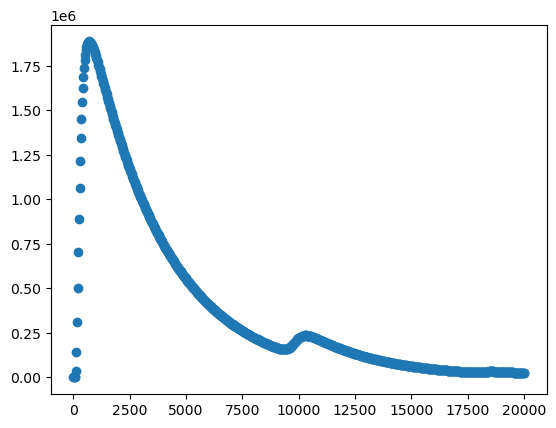

In [23]:
plt.scatter(full_t, true_full_solution[4])

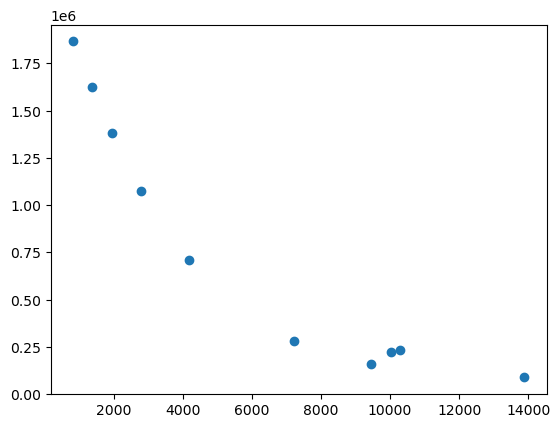

In [131]:
index_values = index_values2
plt.scatter(full_t[index_values], true_full_solution[4][index_values])

In [127]:
index_values

array([ 50,  51,  78,  80,  84,  88, 101, 117, 129, 132, 132, 136, 151,
       160, 179, 181, 190, 199, 204, 217, 218, 219, 221, 244, 265, 282,
       287, 300, 300, 306, 323, 338, 343, 360, 373, 374, 378, 389, 393,
       402, 415, 443, 465, 473, 475, 475, 488, 489, 493, 496])

In [63]:
true_params

{'beta': 4.308e-08,
 'k': 0.0111,
 'd': 0.004169999999999999,
 'p': 0.13644,
 'c': 0.0654,
 'cp': 4e-05,
 'cd': 0.00030000000000000003,
 'ck': 4e-06,
 'r': 0.0001}

In [97]:
optimized_params

{'beta': 6.462e-08,
 'k': 0.0080117498766643,
 'd': 0.0036655000654584225,
 'p': 0.09058303568451029,
 'c': 0.09229629699763017,
 'cp': 3.836257369580914e-05,
 'cd': 0.0003390405326867785,
 'ck': 2.245266306966188e-06,
 'r': 0.00011855506107480936}

In [134]:
start_params

{'beta': 3.949e-08,
 'k': 0.010175,
 'd': 0.0038225,
 'p': 0.12507,
 'c': 0.05995,
 'cp': 4.2000000000000004e-05,
 'cd': 0.00032,
 'ck': 4.2e-06,
 'r': 0.0001}

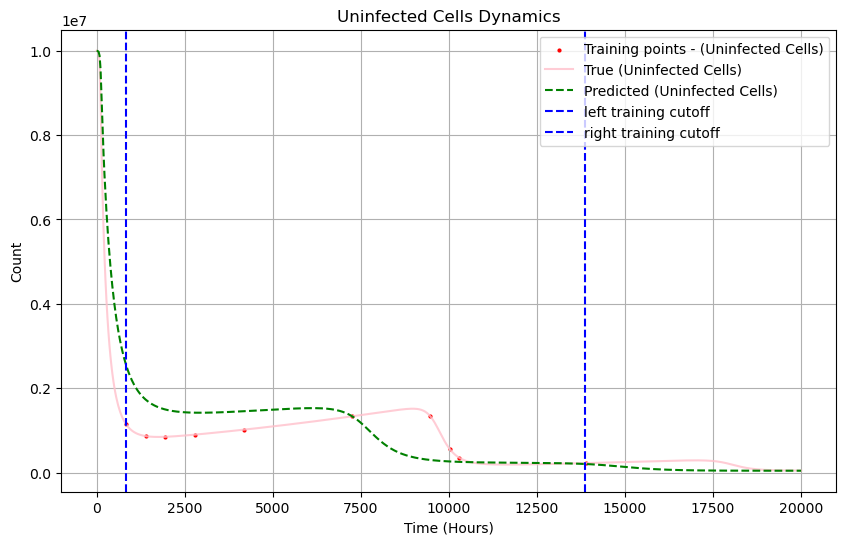

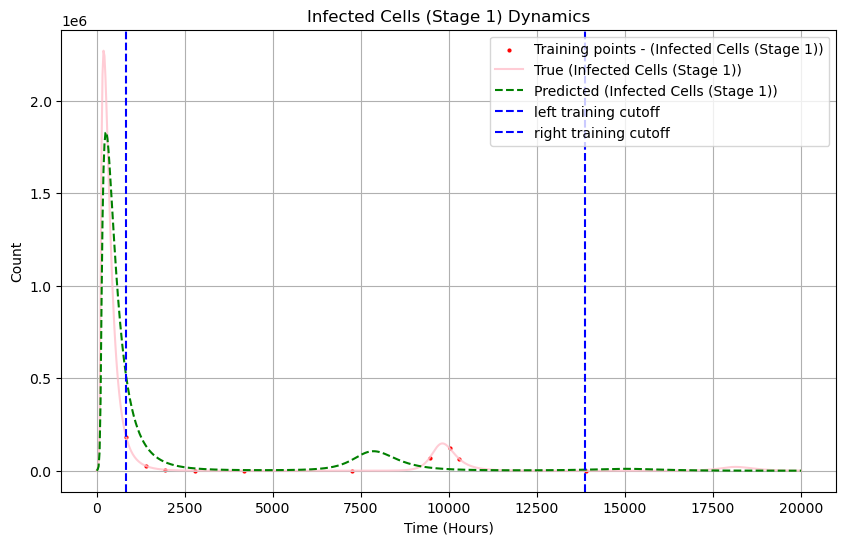

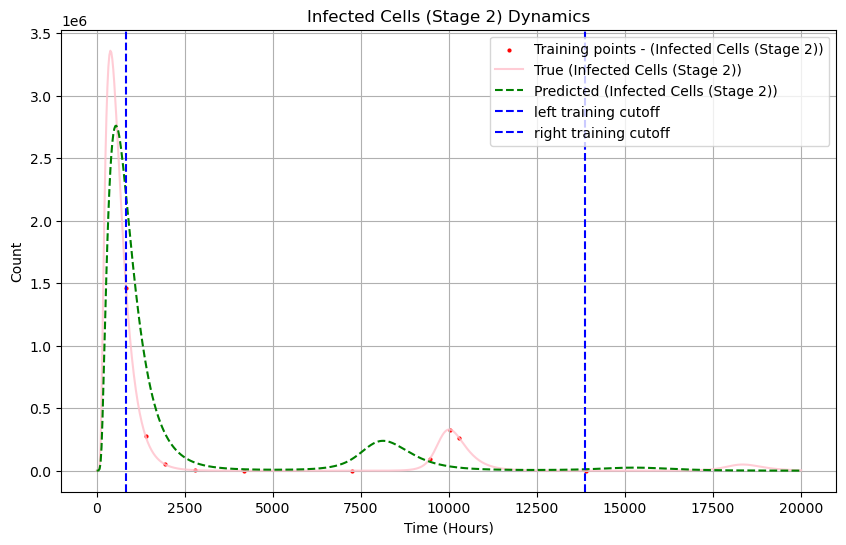

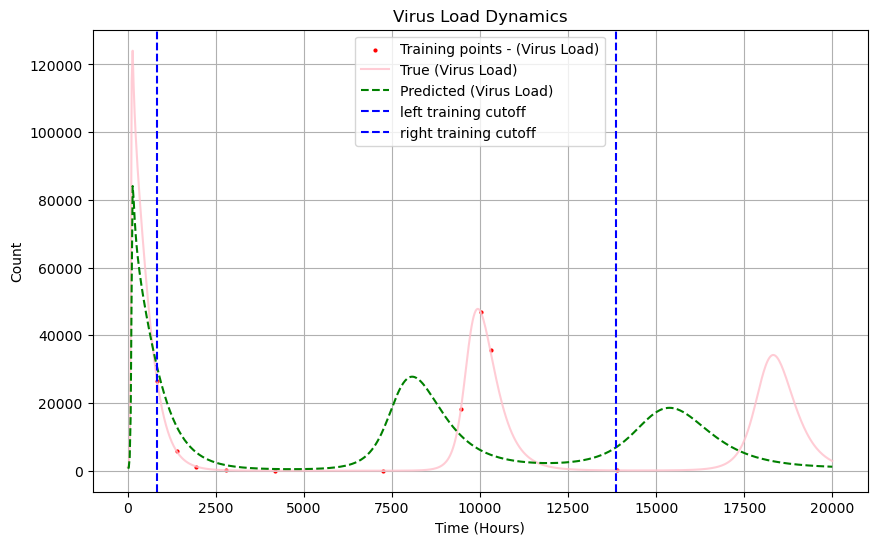

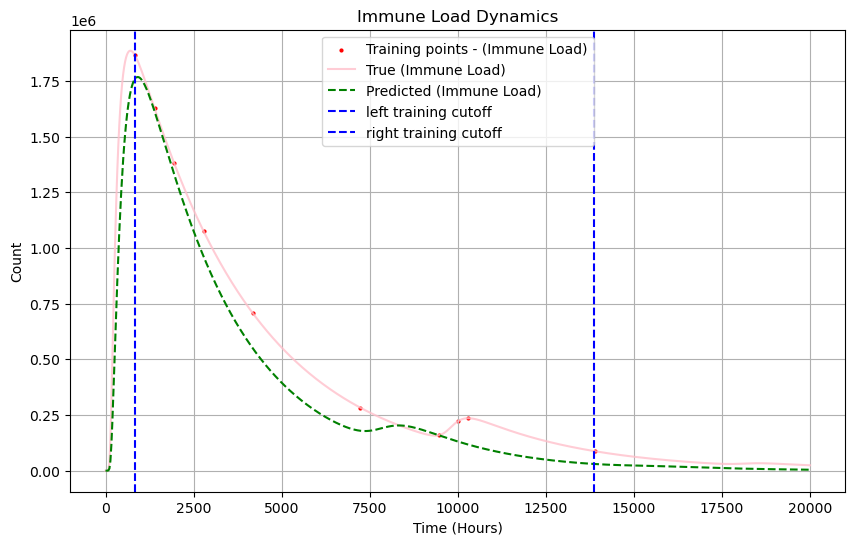

In [133]:
# Plot results
variables = ["Uninfected Cells", "Infected Cells (Stage 1)", "Infected Cells (Stage 2)", "Virus Load", "Immune Load"]
for i, var in enumerate(variables):
    plt.figure(figsize=(10, 6))
    plt.scatter(t[index_values], true_full_solution[i, index_values], label=f"Training points - ({var})", linestyle="solid", s=4, color='red')
    plt.plot(full_t, true_full_solution[i], label=f"True ({var})", linestyle="solid", color='pink', alpha=0.8)
    plt.plot(full_t, optimized_solution[i], label=f"Predicted ({var})", linestyle="dashed", color='green')
    plt.axvline(x = index_values[0] * (20_000 / 720), color = 'b', label = 'left training cutoff', linestyle="dashed")
    plt.axvline(x = index_values[-1] * (20_000 / 720), color = 'b', label = 'right training cutoff', linestyle="dashed")
    
    plt.xlabel("Time (Hours)")
    plt.ylabel("Count")
    plt.title(f"{var} Dynamics")
    plt.legend()
    plt.grid()
    plt.show()

In [161]:
true_full_solution[i, ::10][:36].shape

(36,)

<Axes: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=1.000e+00)'>

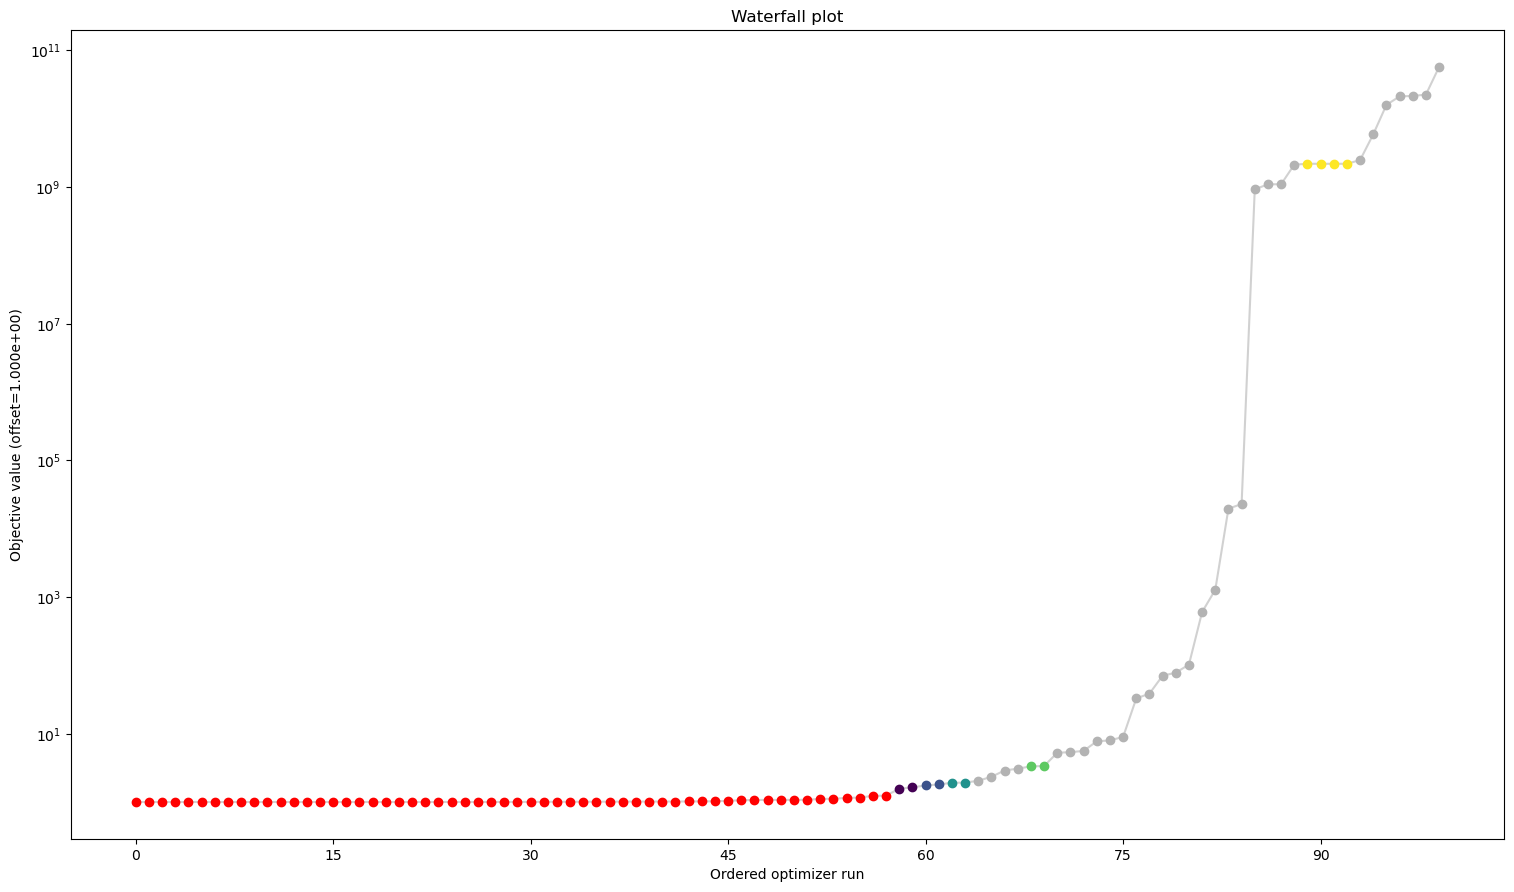

In [135]:
pypesto.visualize.waterfall(result)

## Model Medium

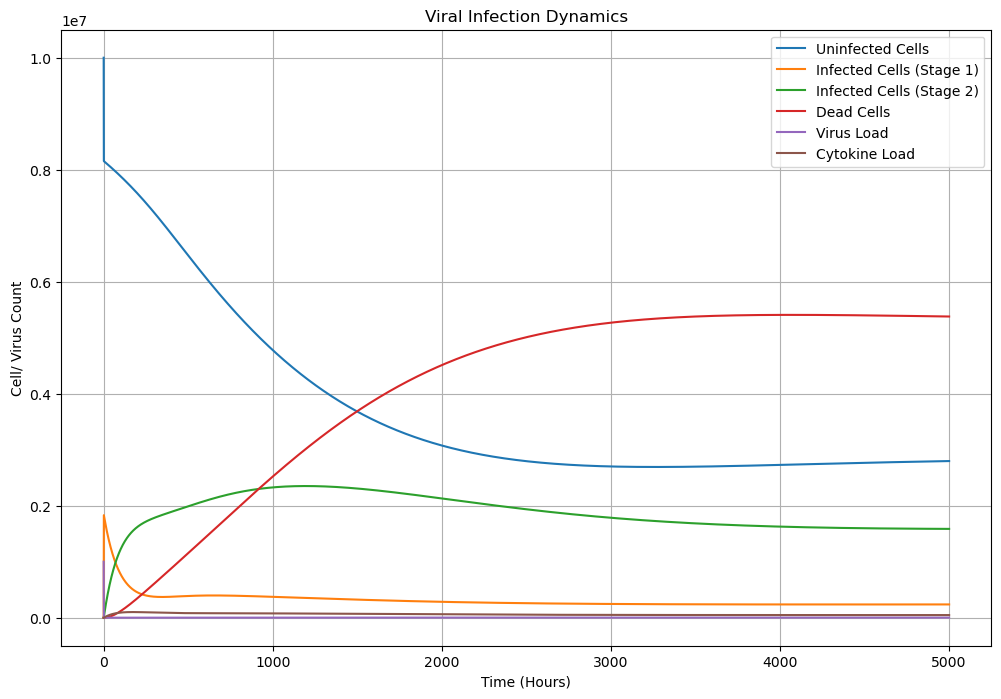

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, r, C_max, avl, cd, cp, ck):
    U, I1, I2, A, V, C = y
    dU_dt = -beta * U * V + r * A
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dA_dt = d * I2 - r * A
    dV_dt = p * I2 - c * V + (V <= 0) * avl - ck * C * V
    dC_dt = cp * I1 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dA_dt, dV_dt, dC_dt]

# Parameters
beta = 7.18*600*1e-10  # infection rate
k = 1.85*600*1e-5      # infected_to_transitioning_conv_rate
d = 2.78*600*1e-6     # death rate
p = 1.09*600*1e-3    # virus production rate
c = 1.09*600*1e-4     # virus decay rate
cd = 5e-3 # Cytokine decay rate.
cp = 1e-3 # Cytokine production rate
ck = 1e-2 # Cytokine kill rate
r = 5e-4 # Cell restoration
C_max = 1e7 #All cells
avl = 1e2 # attacking virus load

# Initial conditions
U0 = 1e7  # initial uninfected cells
I1_0 = 0  # initial infected cells stage 1
I2_0 = 0  # initial infected cells stage 2
A0 = 0    # initial dead cells
V0 = 1e6  # initial virus load
C0 = 0    # cytokine level initial

# Time points (days)
t = np.linspace(0, 5000, 5000)  # simulate for 50 days

# Initial state
y0 = [U0, I1_0, I2_0, A0, V0, C0]

# Solve ODE
solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, U_max, avl, cd, cp, ck))

# Plot results
U, I1, I2, A, V, C = solution.T
plt.figure(figsize=(12, 8))
plt.plot(t, U, label='Uninfected Cells')
plt.plot(t, I1, label='Infected Cells (Stage 1)')
plt.plot(t, I2, label='Infected Cells (Stage 2)')
plt.plot(t, A, label='Dead Cells')
plt.plot(t, V, label='Virus Load')
plt.plot(t, C, label='Cytokine Load')
plt.xlabel('Time (Hours)')
plt.ylabel('Cell/ Virus Count')
plt.legend()
plt.title('Viral Infection Dynamics')
plt.grid()
plt.show()